# Random Forest Classification and Statistical Test on Biomarker data

In [ ]:
#Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')  # Optional: suppress warnings for cleaner output

# Load dataset

#from google.colab import drive
#drive.mount('/content/drive')

#df = pd.read_csv('/content/drive/MyDrive/Before_After.csv')
df = pd.read_csv("https://github.com/arogelg/MATRR-Capstone-Project/blob/main/csv%20files/Before_After.csv?raw=true")

# Drop monkey ID with issues
df = df[df["MATRR ID"] != 10033].copy()

# Define biomarker columns
biomarker_cols = [col for col in df.columns if col.endswith(':') or col.endswith('%:') or col.endswith('%')]

# Metadata features
meta_features = ['mky_gender', 'Cohort', 'Species', 'mky_weight']

# Clean preview
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (248, 49)


Species Cohort  MATRR ID  Date of BC      Timepoint    State  TP:  ALB:  \
0    cyno      2     10016  2006-03-27  H2O induction  sedated  7.0   4.2   
1    cyno      2     10016  2006-10-26  open access 1  sedated  7.9   4.6   
2    cyno      2     10018  2006-03-27  H2O induction  sedated  6.6   3.8   
3    cyno      2     10018  2006-10-26  open access 1  sedated  7.3   4.4   
4    cyno      2     10019  2006-03-27  H2O induction  sedated  6.5   4.1   

   ALKP:  ALT:  ...  RBC:  MCV:  MCH:  MCHC:   PLT:   phase  months_diff  \
0  167.0  45.0  ...  5.73  75.0  24.3   32.5  378.0  before            6   
1   84.0  37.0  ...  5.66  75.0  24.2   32.2  446.0   after            6   
2   94.0  30.0  ...  4.54  78.0  25.3   32.3  378.0  before            6   
3   80.0  18.0  ...  5.02  79.0  25.5   32.2  749.0   after            6   
4  118.0  40.0  ...  5.05  72.0  23.8   32.9  338.0  before            6   

   mky_gender  mky_weight  drinking_category  
0           M        8.18                 LD  
1           M        8.18                 LD  
2           M        7.38                 LD  
3           M        7.38                 LD  
4           M        7.92                 LD  

[5 rows x 49 columns]

In [ ]:
import os

# Create output dir for plots
os.makedirs("figures", exist_ok=True)

def save_and_show_plot(filename_base, tight=True):
    """
    Save current plot to 'figures/' directory as PNG and show it.
    """
    plt.tight_layout() if tight else None
    plt.savefig(f"figures/{filename_base}.png", dpi=300)
    plt.show()


In [ ]:
# -------------------------------------
# Create Delta Dataset
# -------------------------------------

#Identify 'Before' and 'After' records
df_before = df[df['phase'].str.lower().str.contains('before')].copy()
df_after = df[df['phase'].str.lower().str.contains('after')].copy()

#Keep only monkeys with both timepoints
common_ids = set(df_before['MATRR ID']).intersection(set(df_after['MATRR ID']))
df_before = df_before[df_before['MATRR ID'].isin(common_ids)].sort_values('MATRR ID')
df_after = df_after[df_after['MATRR ID'].isin(common_ids)].sort_values('MATRR ID')

#Ensure numeric biomarkers
df_before[biomarker_cols] = df_before[biomarker_cols].apply(pd.to_numeric, errors='coerce')
df_after[biomarker_cols] = df_after[biomarker_cols].apply(pd.to_numeric, errors='coerce')

#Compute deltas
df_delta = df_after[['MATRR ID']].copy()
for biomarker in biomarker_cols:
    df_delta[f'delta_{biomarker}'] = df_after[biomarker].values - df_before[biomarker].values

#Attach metadata from 'after' frame
meta_cols = ['Species', 'Cohort', 'mky_gender', 'mky_weight', 'drinking_category']
df_delta = df_delta.merge(df_after[['MATRR ID'] + meta_cols], on='MATRR ID', how='left')

#Preview
print("Delta dataset shape:", df_delta.shape)
df_delta.head()


Delta dataset shape: (124, 44)


MATRR ID  delta_TP:  delta_ALB:  delta_ALKP:  delta_ALT:  delta_AST:  \
0     10016        0.9         0.4        -83.0        -8.0       -12.0   
1     10018        0.7         0.6        -14.0       -12.0       -16.0   
2     10019        0.3         0.2        -38.0        -9.0       -10.0   
3     10020        0.6         0.3         34.0       -20.0         7.0   
4     10021        0.4         0.2        -51.0       -22.0         3.0   

   delta_GGT:  delta_TBIL:  delta_GLU:  delta_BUN:  ...  delta_RBC:  \
0         8.0          0.1       -18.0        -7.0  ...       -0.07   
1        10.0          0.1       -11.0        -5.0  ...        0.48   
2        10.0          0.2       -13.0        -1.0  ...        0.14   
3         6.0          0.2       -19.0        74.0  ...        0.01   
4        10.0          0.4         3.0         2.0  ...        0.02   

   delta_MCV:  delta_MCH:  delta_MCHC:  delta_PLT:  Species  Cohort  \
0         0.0        -0.1         -0.3        68.0     cyno       2   
1         1.0         0.2         -0.1       371.0     cyno       2   
2         2.0         0.5         -0.3        49.0     cyno       2   
3         2.0        -0.4         -1.5       258.0     cyno       2   
4        -1.0         0.3          1.0       137.0     cyno       2   

   mky_gender  mky_weight  drinking_category  
0           M        8.18                 LD  
1           M        7.38                 LD  
2           M        7.92                 LD  
3           M        7.58                VHD  
4           M        7.86                 LD  

[5 rows x 44 columns]

In [ ]:
#Display the count of NaN in features across the whole dataset
df_delta.isna().sum()

MATRR ID               0
delta_TP:              0
delta_ALB:             0
delta_ALKP:            0
delta_ALT:             0
delta_AST:             3
delta_GGT:             3
delta_TBIL:            1
delta_GLU:             0
delta_BUN:             0
delta_CREA:            0
delta_K:               2
delta_NA:              0
delta_CL:              2
delta_Ca:             61
delta_PHOS:            1
delta_Fe:             62
delta_CHOL:            3
delta_LDH:            62
delta_TRIG:            3
delta_A/G ratio:      62
delta_DBIL:           83
delta_Glob:           61
delta_Amyl:          107
delta_MG:             65
delta_WBC:             1
delta_NEUT%:          20
delta_BAND%:          86
delta_LY%             20
delta_MONO%:          20
delta_EOS%:           20
delta_BASO%:          20
delta_HCT:             1
delta_HGB:             1
delta_RBC:             1
delta_MCV:             1
delta_MCH:             1
delta_MCHC:            1
delta_PLT:             1
Species                0
Cohort                 0
mky_gender             0
mky_weight             0
drinking_category      0
dtype: int64

## Create missingness flags for delta features

In [ ]:
#Create missingness flags for delta features
delta_feature_cols = [col for col in df_delta.columns if col.startswith("delta_") and not col.endswith("_missing")]

for col in delta_feature_cols:
    df_delta[f"{col}_missing"] = df_delta[col].isnull().astype(int)


In [ ]:
#Display column names in dataframe
df_delta.columns

Index(['MATRR ID', 'delta_TP:', 'delta_ALB:', 'delta_ALKP:', 'delta_ALT:',
       'delta_AST:', 'delta_GGT:', 'delta_TBIL:', 'delta_GLU:', 'delta_BUN:',
       'delta_CREA:', 'delta_K:', 'delta_NA:', 'delta_CL:', 'delta_Ca:',
       'delta_PHOS:', 'delta_Fe:', 'delta_CHOL:', 'delta_LDH:', 'delta_TRIG:',
       'delta_A/G ratio:', 'delta_DBIL:', 'delta_Glob:', 'delta_Amyl:',
       'delta_MG:', 'delta_WBC:', 'delta_NEUT%:', 'delta_BAND%:', 'delta_LY%',
       'delta_MONO%:', 'delta_EOS%:', 'delta_BASO%:', 'delta_HCT:',
       'delta_HGB:', 'delta_RBC:', 'delta_MCV:', 'delta_MCH:', 'delta_MCHC:',
       'delta_PLT:', 'Species', 'Cohort', 'mky_gender', 'mky_weight',
       'drinking_category', 'delta_TP:_missing', 'delta_ALB:_missing',
       'delta_ALKP:_missing', 'delta_ALT:_missing', 'delta_AST:_missing',
       'delta_GGT:_missing', 'delta_TBIL:_missing', 'delta_GLU:_missing',
       'delta_BUN:_missing', 'delta_CREA:_missing', 'delta_K:_missing',
       'delta_NA:_missing', 'delta_CL

## Box Plots Delta biomarkers against Drinking Category and Cohorts

In [ ]:
# ---- Define biomarker groups ----
liver_biomarkers = ['ALT:', 'AST:', 'GGT:', 'ALKP:', 'TBIL:', 'DBIL:', 'A/G ratio:', 'Glob:', 'ALB:']
kidney_biomarkers = ['BUN:', 'CREA:', 'K:', 'NA:', 'CL:']
metabolic_biomarkers = ['GLU:', 'CHOL:', 'TRIG:', 'Fe:', 'MG:', 'PHOS:']
hematological_biomarkers = ['WBC:', 'RBC:', 'HGB:', 'HCT:', 'MCV:', 'MCH:', 'MCHC:', 'PLT:']
immune_biomarkers = ['NEUT%:', 'BAND%:', 'LY%', 'MONO%:', 'EOS%:', 'BASO%:']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_delta_biomarker_group(df, biomarker_list, group_name):
    """
    Plots delta biomarker group distributions against drinking category and cohort,
    using a distinct color palette for many cohorts.
    """

    # Build list of delta columns to use
    delta_cols = [f"delta_{b}" for b in biomarker_list if f"delta_{b}" in df.columns]
    if not delta_cols:
        print(f"Skipping {group_name}: No valid delta columns found.")
        return

    # Melt the data to long format
    df_long = df[['drinking_category', 'Cohort'] + delta_cols].melt(
        id_vars=['drinking_category', 'Cohort'],
        value_vars=delta_cols,
        var_name='Biomarker',
        value_name='Value'
    )

    # Remove delta_ prefix for prettier facet labels
    df_long['Biomarker'] = df_long['Biomarker'].str.replace('delta_', '')

    # Get sorted list of unique cohorts
    unique_cohorts = sorted(df['Cohort'].dropna().unique())
    n_cohorts = len(unique_cohorts)

    # Define a distinct color palette
    palette = sns.color_palette("tab20", n_colors=n_cohorts)
    cohort_palette = dict(zip(unique_cohorts, palette))

    # Plot: Boxplot by drinking category, colored by cohort
    g = sns.catplot(
        data=df_long, x="drinking_category", y="Value",
        hue="Cohort", col="Biomarker", col_wrap=3,
        kind="box", height=4, aspect=1,
        sharey=False, palette=cohort_palette
    )
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"{group_name} Delta Biomarkers by Drinking Category (Colored by Cohort)", fontsize=16)
    g.add_legend(title="Cohort")
    save_and_show_plot(f"boxplot_{group_name}")


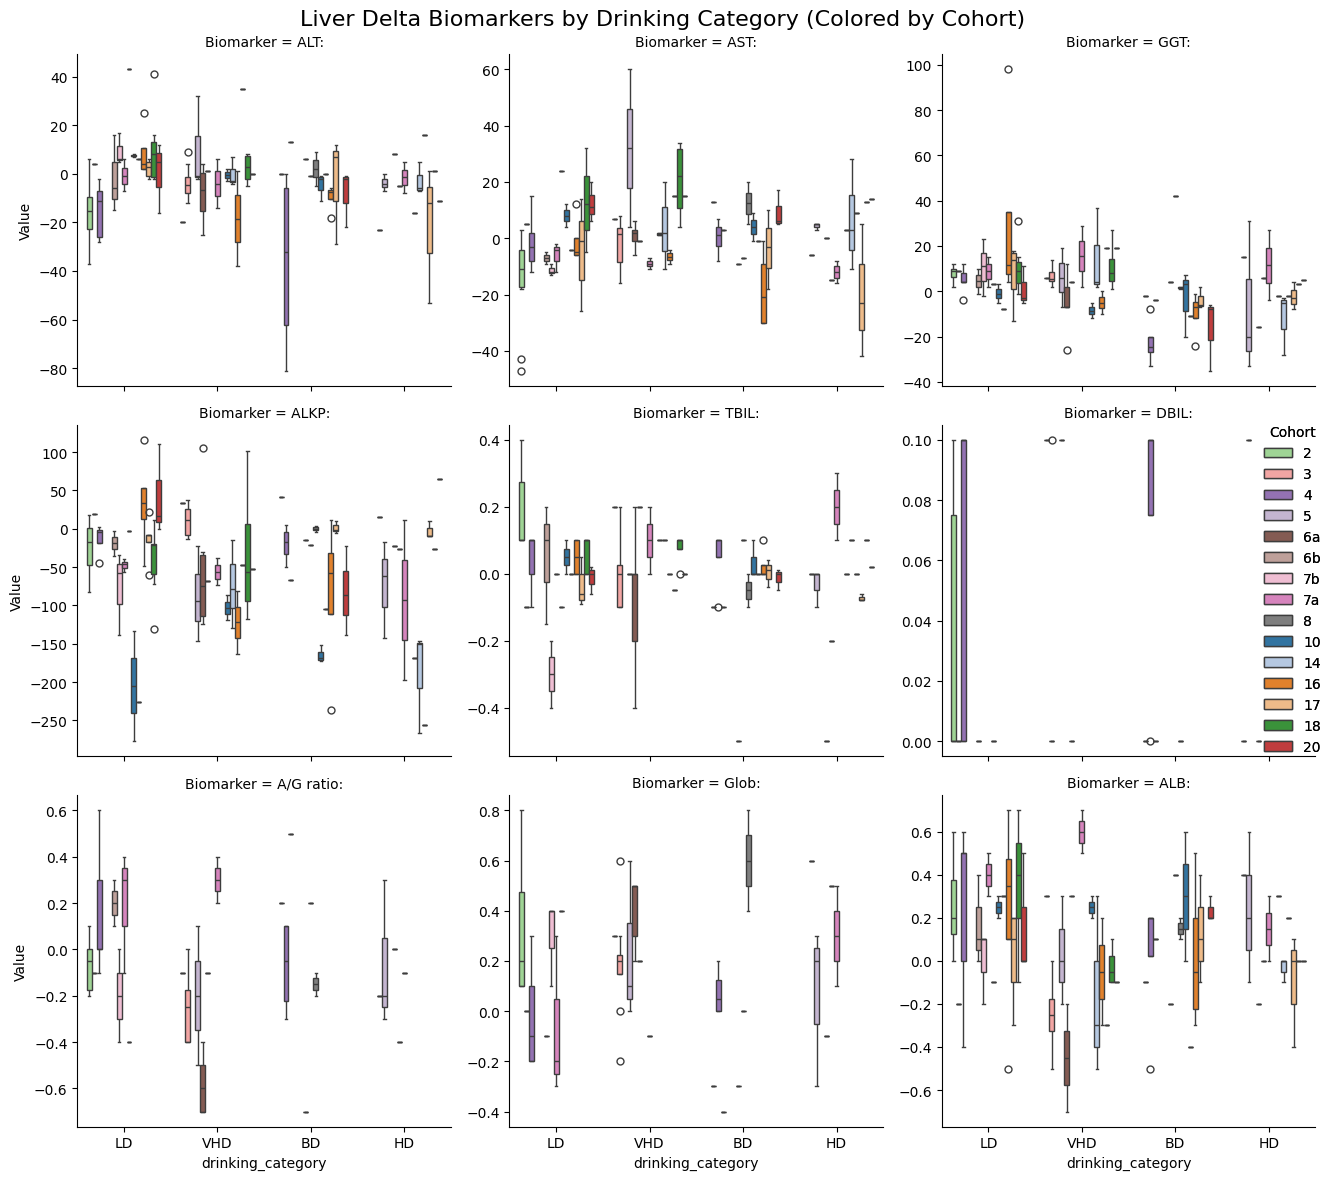

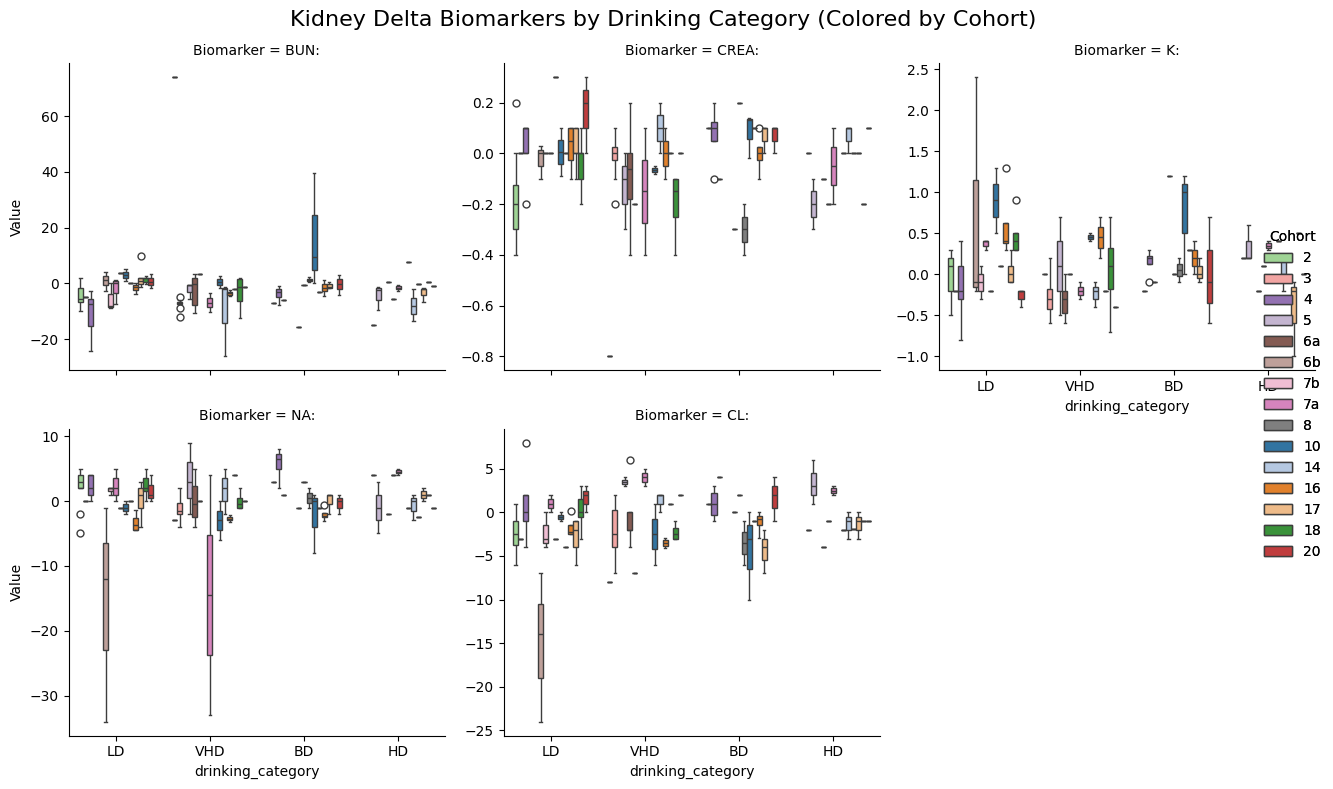

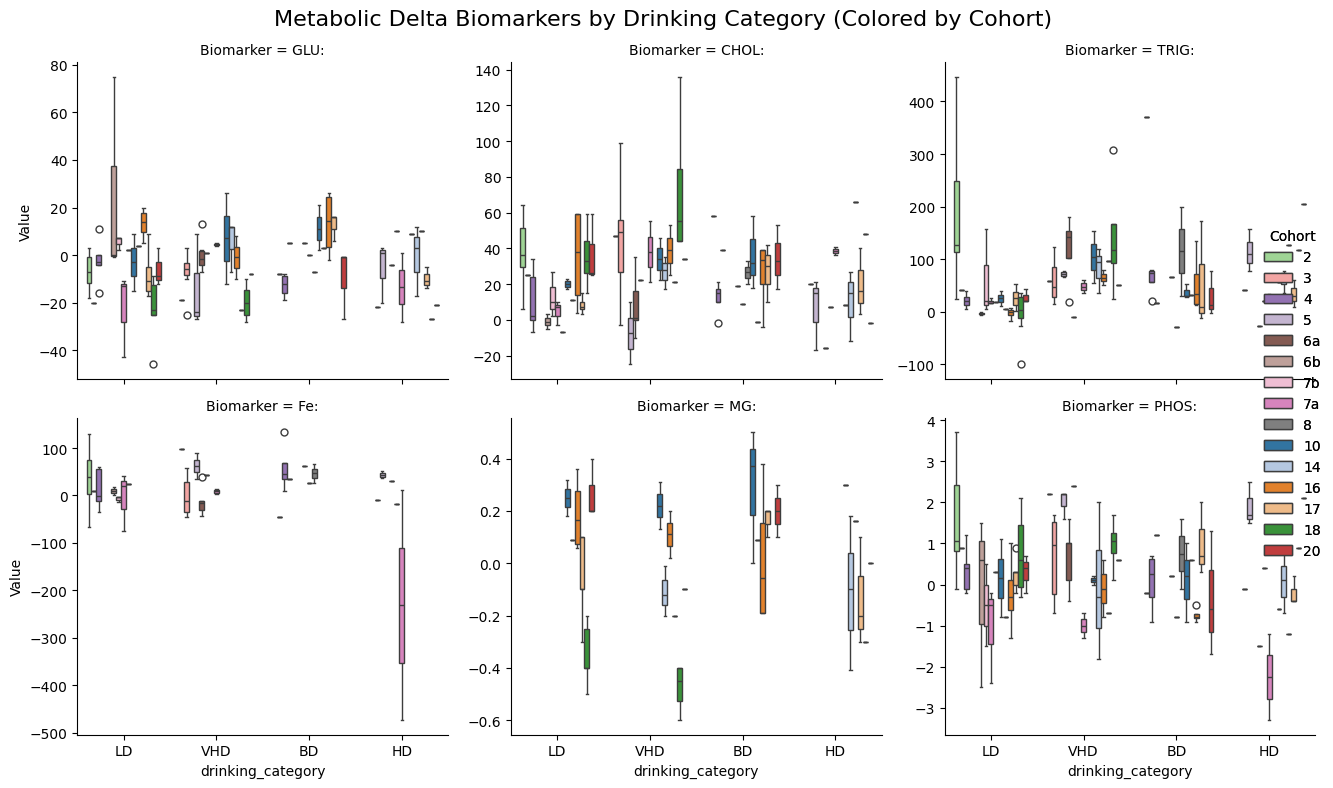

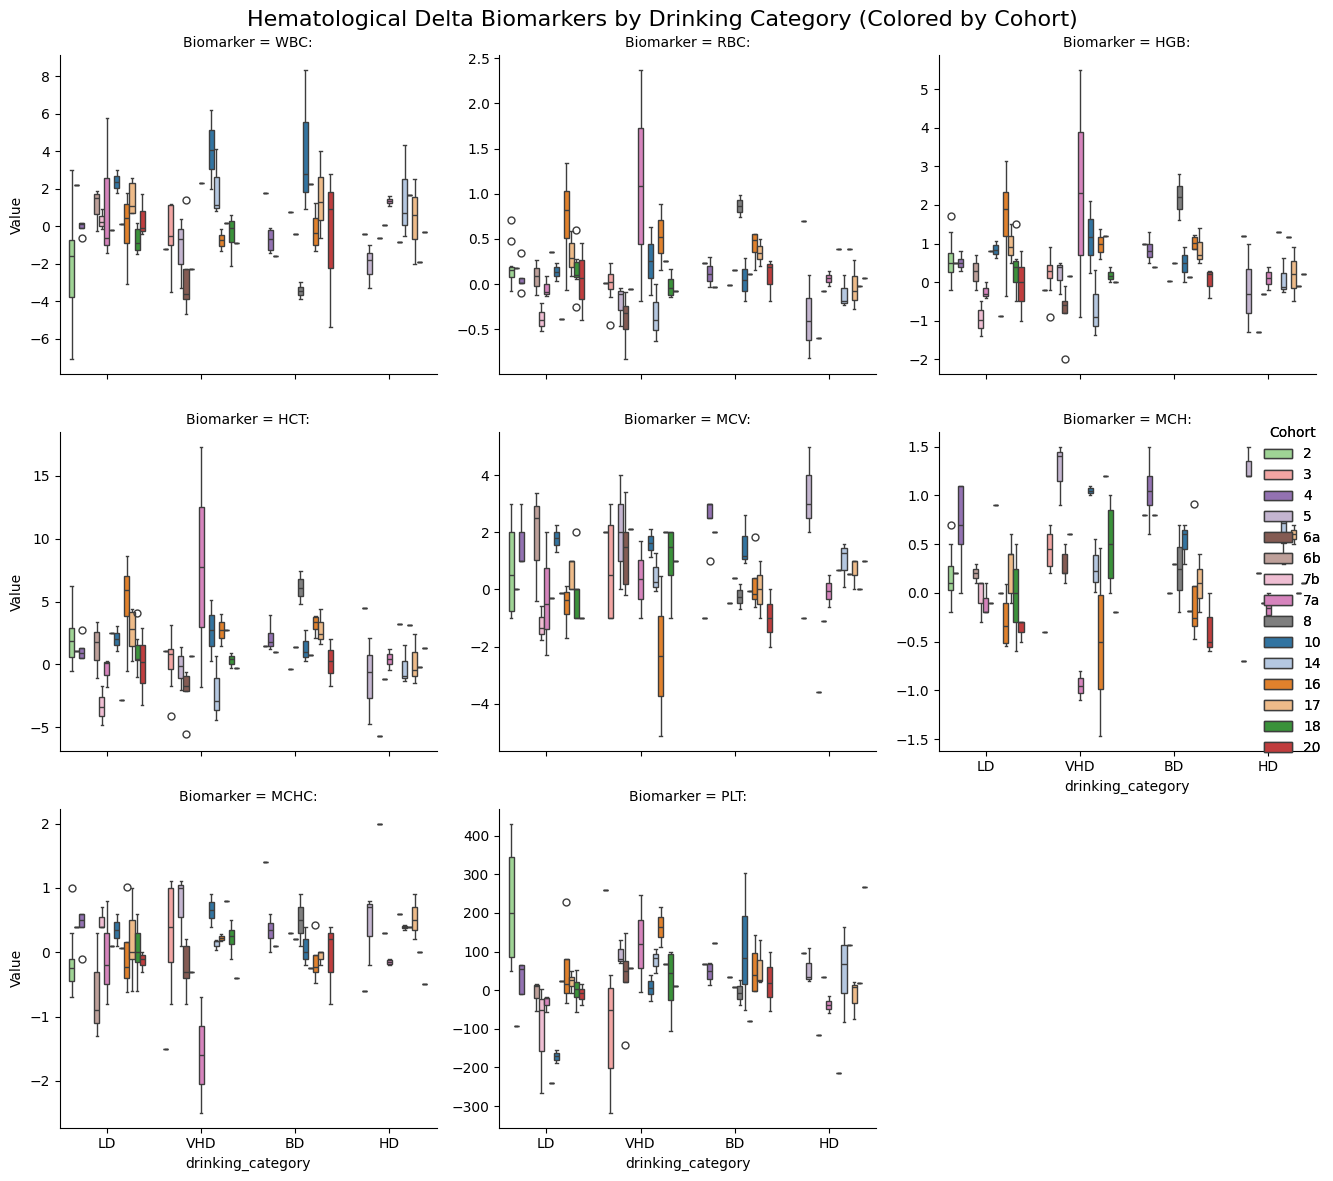

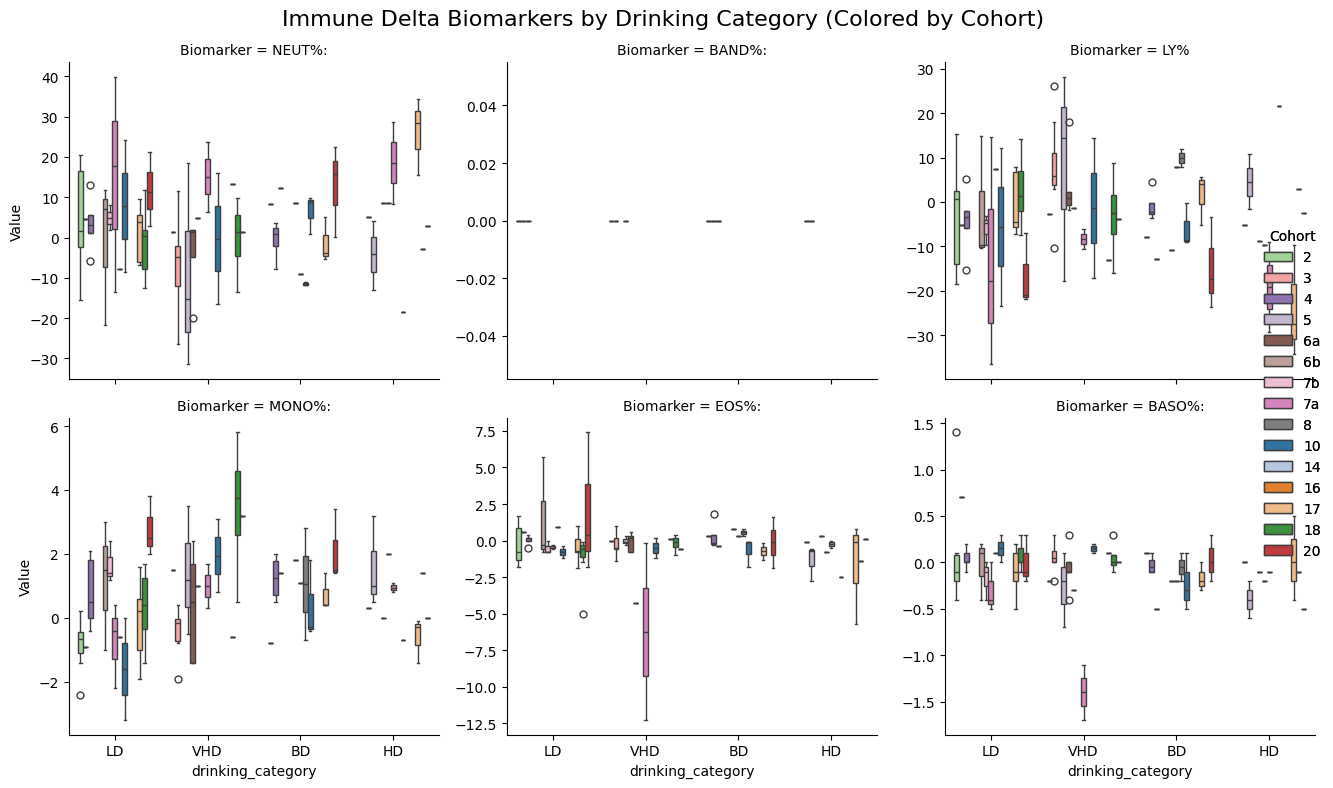

In [ ]:
# Call updated plotting function for delta data
plot_delta_biomarker_group(df_delta, liver_biomarkers, "Liver")
plot_delta_biomarker_group(df_delta, kidney_biomarkers, "Kidney")
plot_delta_biomarker_group(df_delta, metabolic_biomarkers, "Metabolic")
plot_delta_biomarker_group(df_delta, hematological_biomarkers, "Hematological")
plot_delta_biomarker_group(df_delta, immune_biomarkers, "Immune")


Figure: Distribution of delta values for {biomarker} across drinking categories, annotated with statistically significant group differences via Dunn’s test. This visualization supports identification of biomarkers with non-random variance by consumption group.

## Apply Kruskal-Wallis test per biomarker.
### This checks if at least one group differs significantly in distribution for each delta biomarker.

In [ ]:
!pip install -q dataframe-image
import dataframe_image as dfi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 19.1 MB/s eta 0:00:00


In [ ]:
from scipy.stats import kruskal
import pandas as pd

# Store results
kruskal_results = []

# Loop through all delta biomarkers
for biomarker in [col for col in df_delta.columns if col.startswith("delta_")]:
    try:
        # Collect non-null values for each drinking category
        groups = [
            df_delta[df_delta["drinking_category"] == cat][biomarker].dropna()
            for cat in df_delta["drinking_category"].unique()
        ]

        # Ensure at least 2 groups have values
        valid_groups = [g for g in groups if len(g) > 0]
        if len(valid_groups) < 2:
            continue

        # Apply Kruskal-Wallis test
        stat, pval = kruskal(*valid_groups)

        # Append result
        kruskal_results.append({
            "Biomarker": biomarker.replace("delta_", ""),
            "Kruskal_Wallis_H": stat,
            "p_value": pval
        })
    except Exception as e:
        kruskal_results.append({
            "Biomarker": biomarker.replace("delta_", ""),
            "Kruskal_Wallis_H": None,
            "p_value": None,
            #"Error": str(e)
        })

# Convert to DataFrame
df_kruskal = pd.DataFrame(kruskal_results)

# Add significance annotation
df_kruskal["Significant"] = df_kruskal["p_value"].apply(
    lambda p: "p < 0.05" if pd.notnull(p) and p < 0.05 else ""
)

# Sort by lowest p-value
df_kruskal = df_kruskal.sort_values(by="p_value", ascending=True)

# Display top results
print("Top Biomarkers by Kruskal-Wallis Test (Lowest p-values):")
display(df_kruskal.head(20))

import dataframe_image as dfi
from concurrent.futures import ThreadPoolExecutor

# Save Kruskal-Wallis top biomarkers using ThreadPoolExecutor
def export_in_thread(df, filename):
    dfi.export(df, filename)

with ThreadPoolExecutor(max_workers=1) as executor:
    executor.submit(export_in_thread, df_kruskal_top, 'figures/kruskal_top_biomarkers.png')

Top Biomarkers by Kruskal-Wallis Test (Lowest p-values):


Biomarker  Kruskal_Wallis_H   p_value Significant
5          GGT:         26.510865  0.000007    p < 0.05
1          ALB:         17.841137  0.000474    p < 0.05
33         RBC:         16.202159  0.001031    p < 0.05
18        TRIG:         15.155354  0.001689    p < 0.05
31         HCT:         12.519436  0.005800    p < 0.05
32         HGB:         11.701895  0.008477    p < 0.05
17         LDH:         11.078220  0.011310    p < 0.05
10           K:         11.054109  0.011437    p < 0.05
19   A/G ratio:          9.809944  0.020253    p < 0.05
0           TP:          8.881558  0.030908    p < 0.05
35         MCH:          8.725133  0.033178    p < 0.05
48   K:_missing          8.401639  0.038401    p < 0.05
23          MG:          8.294349  0.040304    p < 0.05
9         CREA:          6.967033  0.072956            
28       MONO%:          6.321346  0.096981            
16        CHOL:          5.575035  0.134219            
50  CL:_missing          5.337512  0.148687            
7          GLU:          5.078317  0.166151            
34         MCV:          4.981337  0.173169            
14        PHOS:          4.863821  0.182045

## Results:
To assess whether specific biomarkers significantly vary across drinking categories, we applied the non-parametric Kruskal-Wallis H-test to each delta biomarker. This approach avoids assumptions of normality and is well-suited for comparing biomarker distributions across three or more independent groups.

The analysis identified several biomarkers with statistically significant differences (p < 0.05), including GGT, Albumin (ALB), Red Blood Cell count (RBC), Triglycerides (TRIG), and Hematocrit (HCT). Notably, GGT — a well-known liver enzyme involved in alcohol metabolism — showed the strongest statistical signal, supporting its potential relevance in differentiating drinking behaviors. Hematological markers (e.g., RBC, HCT, HGB, MCH) also emerged as significant, suggesting that alcohol consumption may impact red cell indices, although biological interpretation should be approached cautiously.

Interestingly, some missingness flags (e.g., K:_missing, CL:_missing) also showed statistical association with drinking category, potentially reflecting systematic missingness related to sample quality or timing.

While statistical significance does not confirm biological causality, these findings provide a preliminary shortlist of candidate biomarkers that may warrant further investigation. These results guide the next phase of analysis: using predictive models to explore which biomarkers (alone or in combination) are most informative for classifying drinking categories — and, conversely, which biomarkers appear most influenced by alcohol exposure.

## Apply Dunn's Test
### Helps identify which specific drinking categories differ for each significant biomarker.

### Handles unequal group sizes

In [ ]:
!pip install scikit-posthocs # Install the missing scikit-posthocs package

In [ ]:
!pip install dataframe_image>=0.1.1 # Update dataframe_image to a version with async_export

In [ ]:
import asyncio
import pandas as pd
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
import dataframe_image as dfi

# Use the same top biomarkers from Kruskal-Wallis
significant_biomarkers = df_kruskal[df_kruskal['p_value'] < 0.05]['Biomarker'].tolist()

# Store all Dunn results
dunn_results = []

for biomarker in significant_biomarkers:
    # Drop missing values for the biomarker
    data = df_delta[['drinking_category', f'delta_{biomarker}']].dropna()

    # Run Dunn’s test
    dunn_df = sp.posthoc_dunn(
        data,
        val_col=f'delta_{biomarker}',
        group_col='drinking_category',
        p_adjust='holm'  # safer than bonferroni
    )

    # Flatten results to long format
    dunn_long = dunn_df.stack().reset_index()
    dunn_long.columns = ['Group1', 'Group2', 'Corrected_p']
    dunn_long['Biomarker'] = biomarker
    dunn_long = dunn_long[dunn_long['Group1'] != dunn_long['Group2']]  # remove diagonals

    # Filter to significant only (p < 0.05)
    dunn_long = dunn_long[dunn_long['Corrected_p'] < 0.05]

    dunn_results.append(dunn_long)

# Combine all results
df_dunn = pd.concat(dunn_results, ignore_index=True)
df_dunn = df_dunn.sort_values(by=['Biomarker', 'Corrected_p'])

# Save Dunn’s significant comparisons
df_dunn_top = df_dunn.groupby("Biomarker").head(2)  # Top 2 comparisons per biomarker

# Use asyncio.run to execute dfi.export in a separate event loop
#asyncio.run(dfi.async_export(df_dunn_top, 'figures/dunn_significant_pairs.png'))

# Display results
print("Pairwise Dunn’s Test Results (p < 0.05):")
display(df_dunn.head(20))  # show top 20

Pairwise Dunn’s Test Results (p < 0.05):


Group1 Group2  Corrected_p   Biomarker
26     LD    VHD     0.016201  A/G ratio:
27    VHD     LD     0.016201  A/G ratio:
6      LD    VHD     0.000157        ALB:
7     VHD     LD     0.000157        ALB:
0      BD     LD     0.000009        GGT:
3      LD     BD     0.000009        GGT:
1      BD    VHD     0.001442        GGT:
5     VHD     BD     0.001442        GGT:
2      HD     LD     0.021606        GGT:
4      LD     HD     0.021606        GGT:
16     BD    VHD     0.007372        HCT:
17    VHD     BD     0.007372        HCT:
18     BD    VHD     0.008869        HGB:
19    VHD     BD     0.008869        HGB:
23     LD    VHD     0.025879          K:
25    VHD     LD     0.025879          K:
22     BD    VHD     0.041289          K:
24    VHD     BD     0.041289          K:
20     BD     LD     0.006072        LDH:
21     LD     BD     0.006072        LDH:

## Results Post-Hoc Pairwise Comparisons (Dunn’s Test)

To further investigate the significant effects observed in the Kruskal-Wallis analysis, we conducted post-hoc pairwise comparisons using Dunn’s test with Holm correction. This analysis helps identify which specific drinking category pairs differ significantly in biomarker delta values.

Key Findings:
GGT: Strong and consistent differences across multiple category pairs:
BD vs LD (p < 0.00001), BD vs VHD (p ≈ 0.0014), and HD vs LD (p ≈ 0.022).
This reinforces GGT's potential as a discriminative biomarker linked to alcohol exposure intensity.

ALB (Albumin): Significant reduction or change between LD and VHD (p < 0.0002), suggesting possible hepatic stress or nutritional shifts in very heavy drinkers.

A/G ratio: Differed significantly between LD and VHD (p ≈ 0.016), consistent with known liver-related impacts of chronic drinking on globulin/albumin balance.

Hematological markers:
HCT and HGB showed significant differences between BD and VHD, hinting at altered oxygen-carrying capacity or potential hematopoietic effects of sustained alcohol use.
LDH and K+: Changes in LDH (p ≈ 0.006) and potassium (K:, p ≈ 0.026–0.041) suggest possible metabolic stress or electrolyte imbalances across drinking categories.

Interpretation:
These results support the hypothesis that increasing drinking intensity corresponds to biologically relevant alterations in liver function, hematological profiles, and electrolyte balance. However, caution is warranted—sample sizes are modest and multiple comparisons can inflate false positives, even with correction.

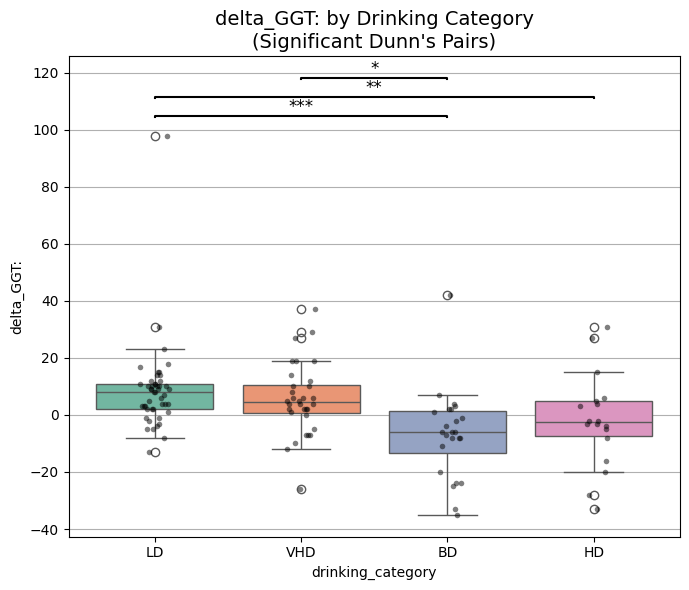

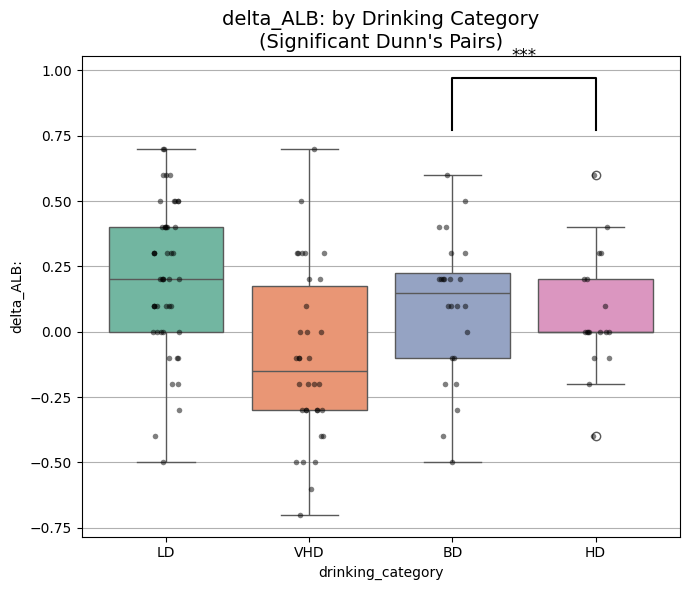

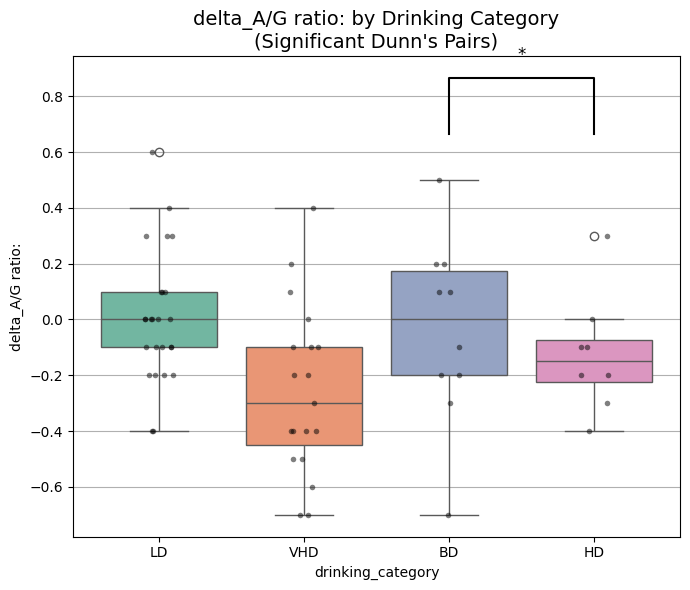

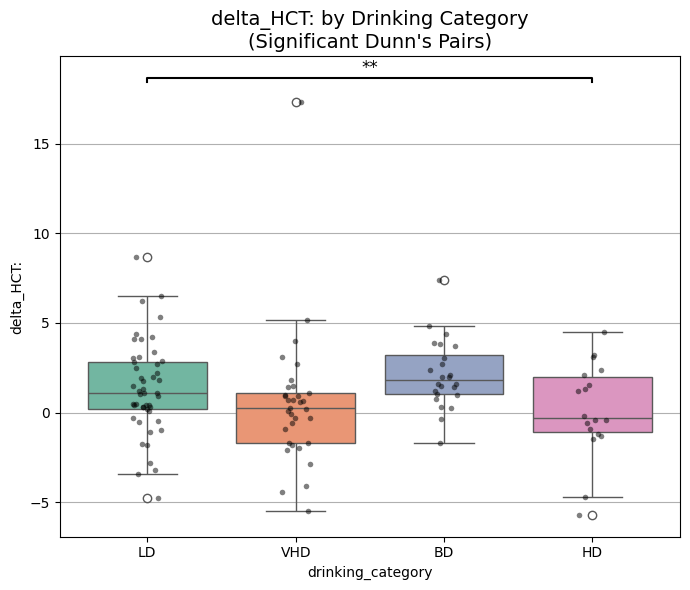

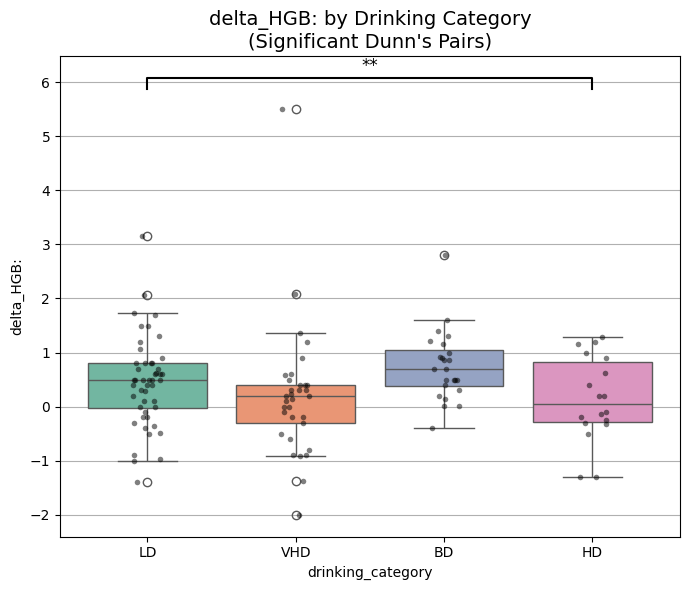

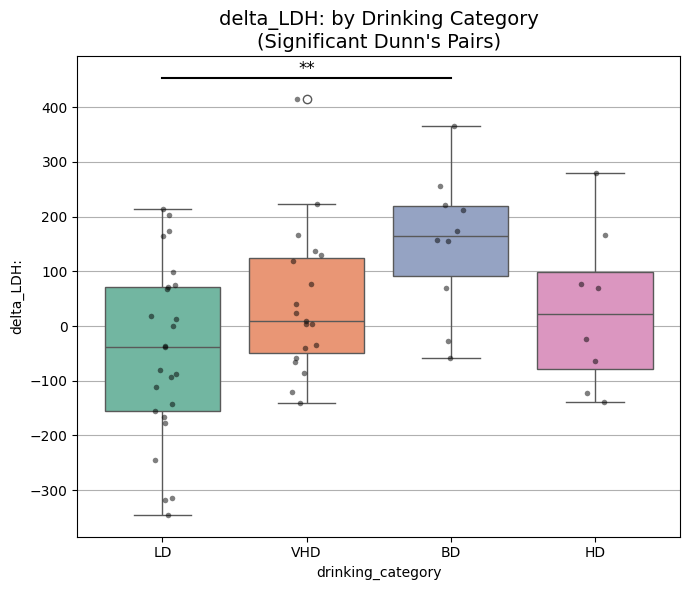

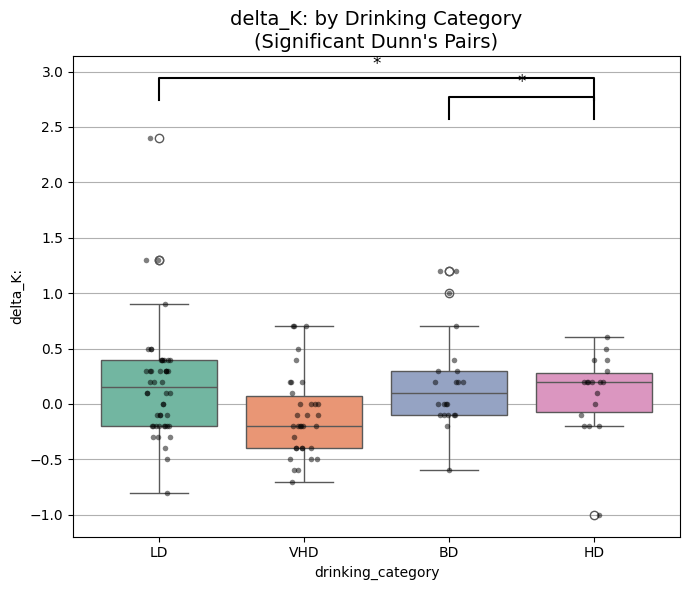

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Significant delta biomarkers (use prefix to match delta columns)
significant_delta_biomarkers = [
    'delta_GGT:', 'delta_ALB:', 'delta_A/G ratio:',
    'delta_HCT:', 'delta_HGB:', 'delta_LDH:', 'delta_K:'
]

# Pairwise significance: biomarker -> [((group1, group2), p_value)]
delta_sig_pairs = {
    'delta_GGT:': [(('BD', 'LD'), 0.000009), (('BD', 'VHD'), 0.001442), (('HD', 'LD'), 0.021606)],
    'delta_ALB:': [(('LD', 'VHD'), 0.000157)],
    'delta_A/G ratio:': [(('LD', 'VHD'), 0.016201)],
    'delta_HCT:': [(('BD', 'VHD'), 0.007372)],
    'delta_HGB:': [(('BD', 'VHD'), 0.008869)],
    'delta_LDH:': [(('BD', 'LD'), 0.006072)],
    'delta_K:': [(('LD', 'VHD'), 0.025879), (('BD', 'VHD'), 0.041289)],
}

# -----------------------------------
# Plot function using df_delta
# -----------------------------------

def plot_delta_biomarker(df, delta_biomarker, sig_pairs):
    plt.figure(figsize=(7, 6))
    ax = sns.boxplot(data=df, x='drinking_category', y=delta_biomarker, palette="Set2")
    sns.stripplot(data=df, x='drinking_category', y=delta_biomarker, color='black', size=4, alpha=0.5, jitter=True)

    # Sort x-axis labels for consistency
    categories = sorted(df['drinking_category'].dropna().unique())
    cat_pos = {cat: i for i, cat in enumerate(categories)}

    ymax = df[delta_biomarker].max(skipna=True)
    y_offset = (ymax - df[delta_biomarker].min(skipna=True)) * 0.05
    line_height = y_offset

    for i, ((g1, g2), pval) in enumerate(sig_pairs):
        x1, x2 = cat_pos[g1], cat_pos[g2]
        y = ymax + line_height * (i + 1)
        plt.plot([x1, x1, x2, x2], [y, y + 0.2, y + 0.2, y], lw=1.5, c='k')

        # Stars for significance
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = 'ns'
        plt.text((x1 + x2) / 2, y + 0.25, stars, ha='center', va='bottom', fontsize=12)

    plt.title(f"{delta_biomarker} by Drinking Category\n(Significant Dunn's Pairs)", fontsize=14)
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

# Generate plots

for delta_bio in significant_delta_biomarkers:
    if delta_bio in df_delta.columns:
        plot_delta_biomarker(df_delta, delta_bio, delta_sig_pairs.get(delta_bio, []))


## Correlation Heatmap

### Shows the Pearson correlation between delta_* biomarkers to detect multicollinearity, clusters of co-varying markers, or possible redundancies.

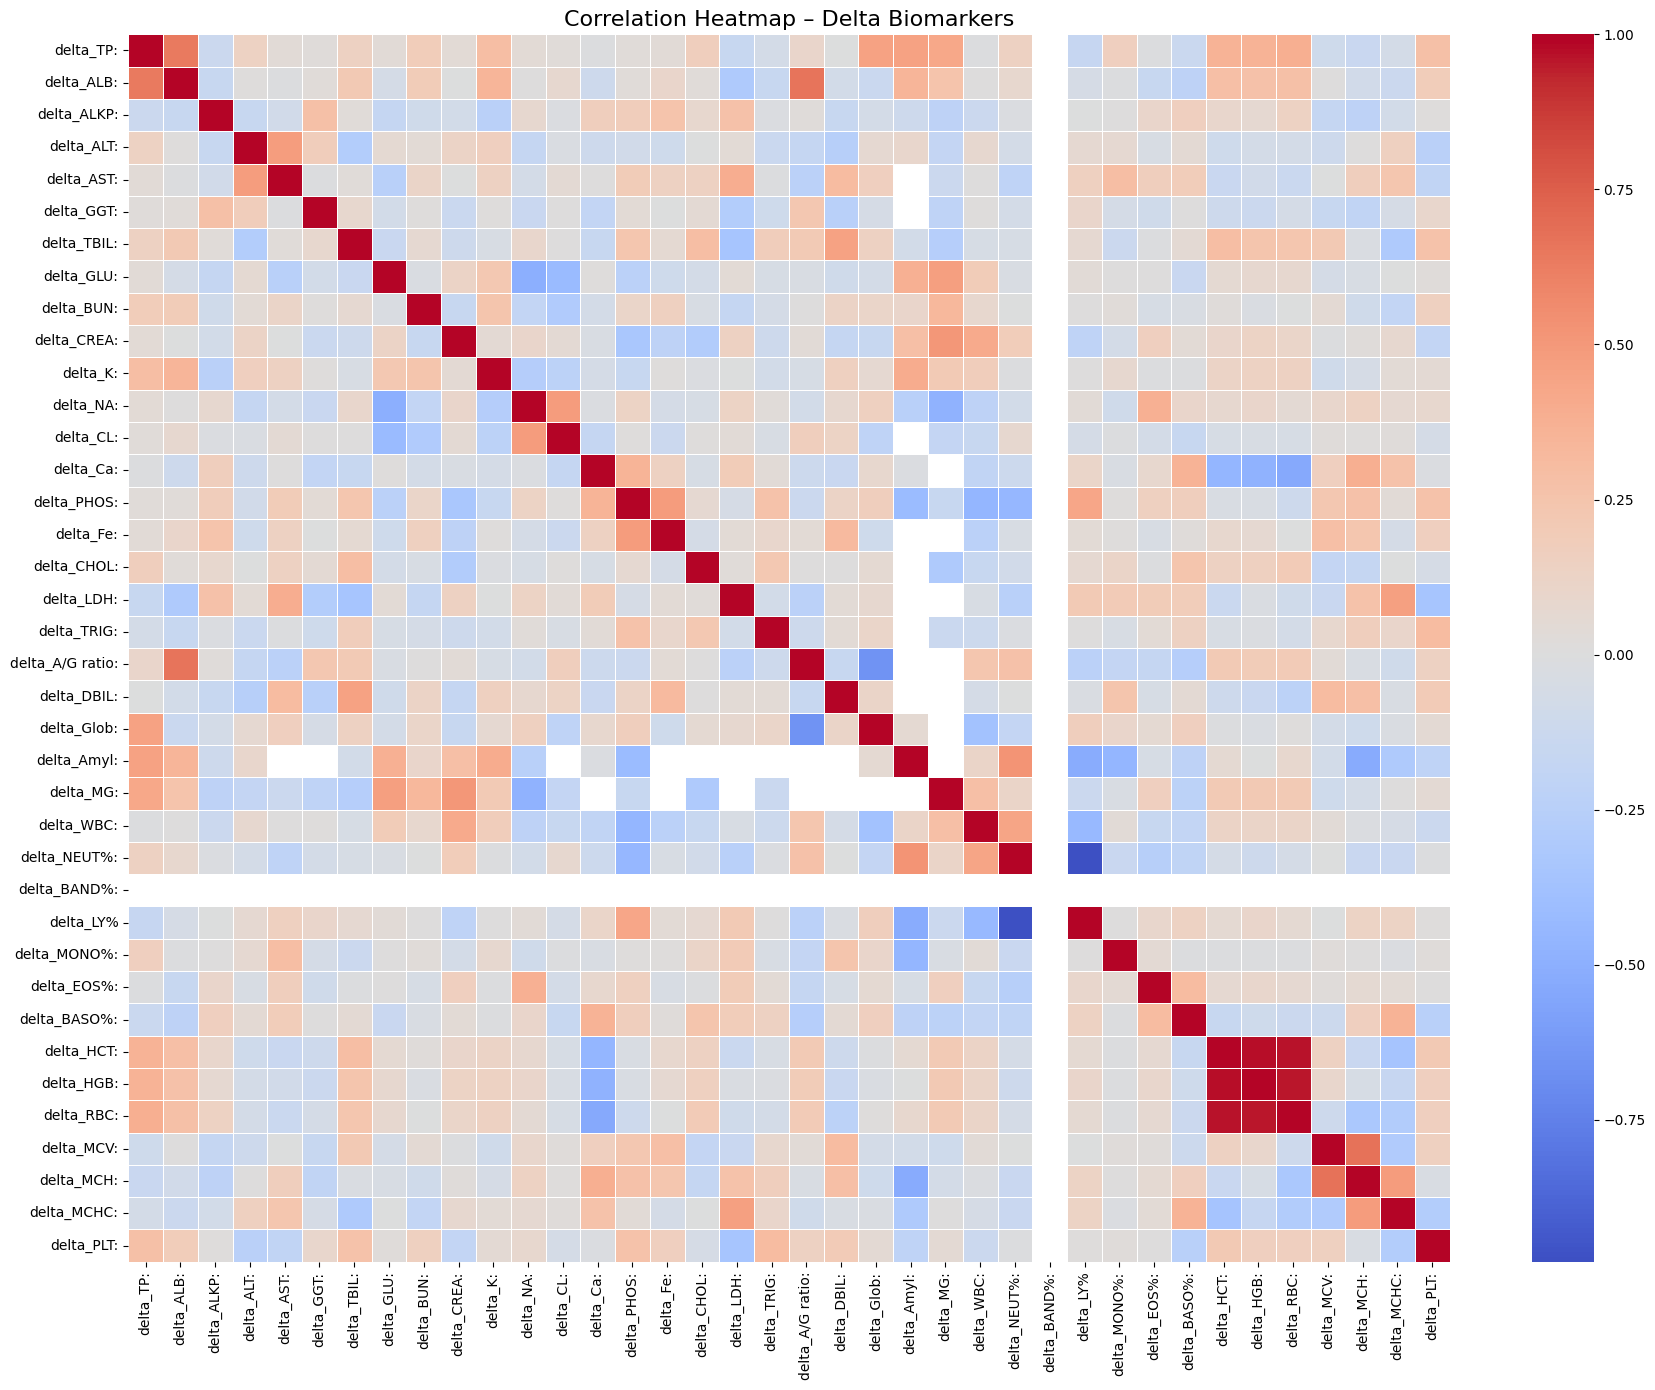

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for delta biomarker columns only (exclude _missing flags)
delta_biomarker_cols_only = [col for col in df_delta.columns if col.startswith("delta_") and not col.endswith("_missing")]

# Compute Pearson correlation
corr_matrix = df_delta[delta_biomarker_cols_only].corr(method='pearson')

# Plot
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap – Delta Biomarkers", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


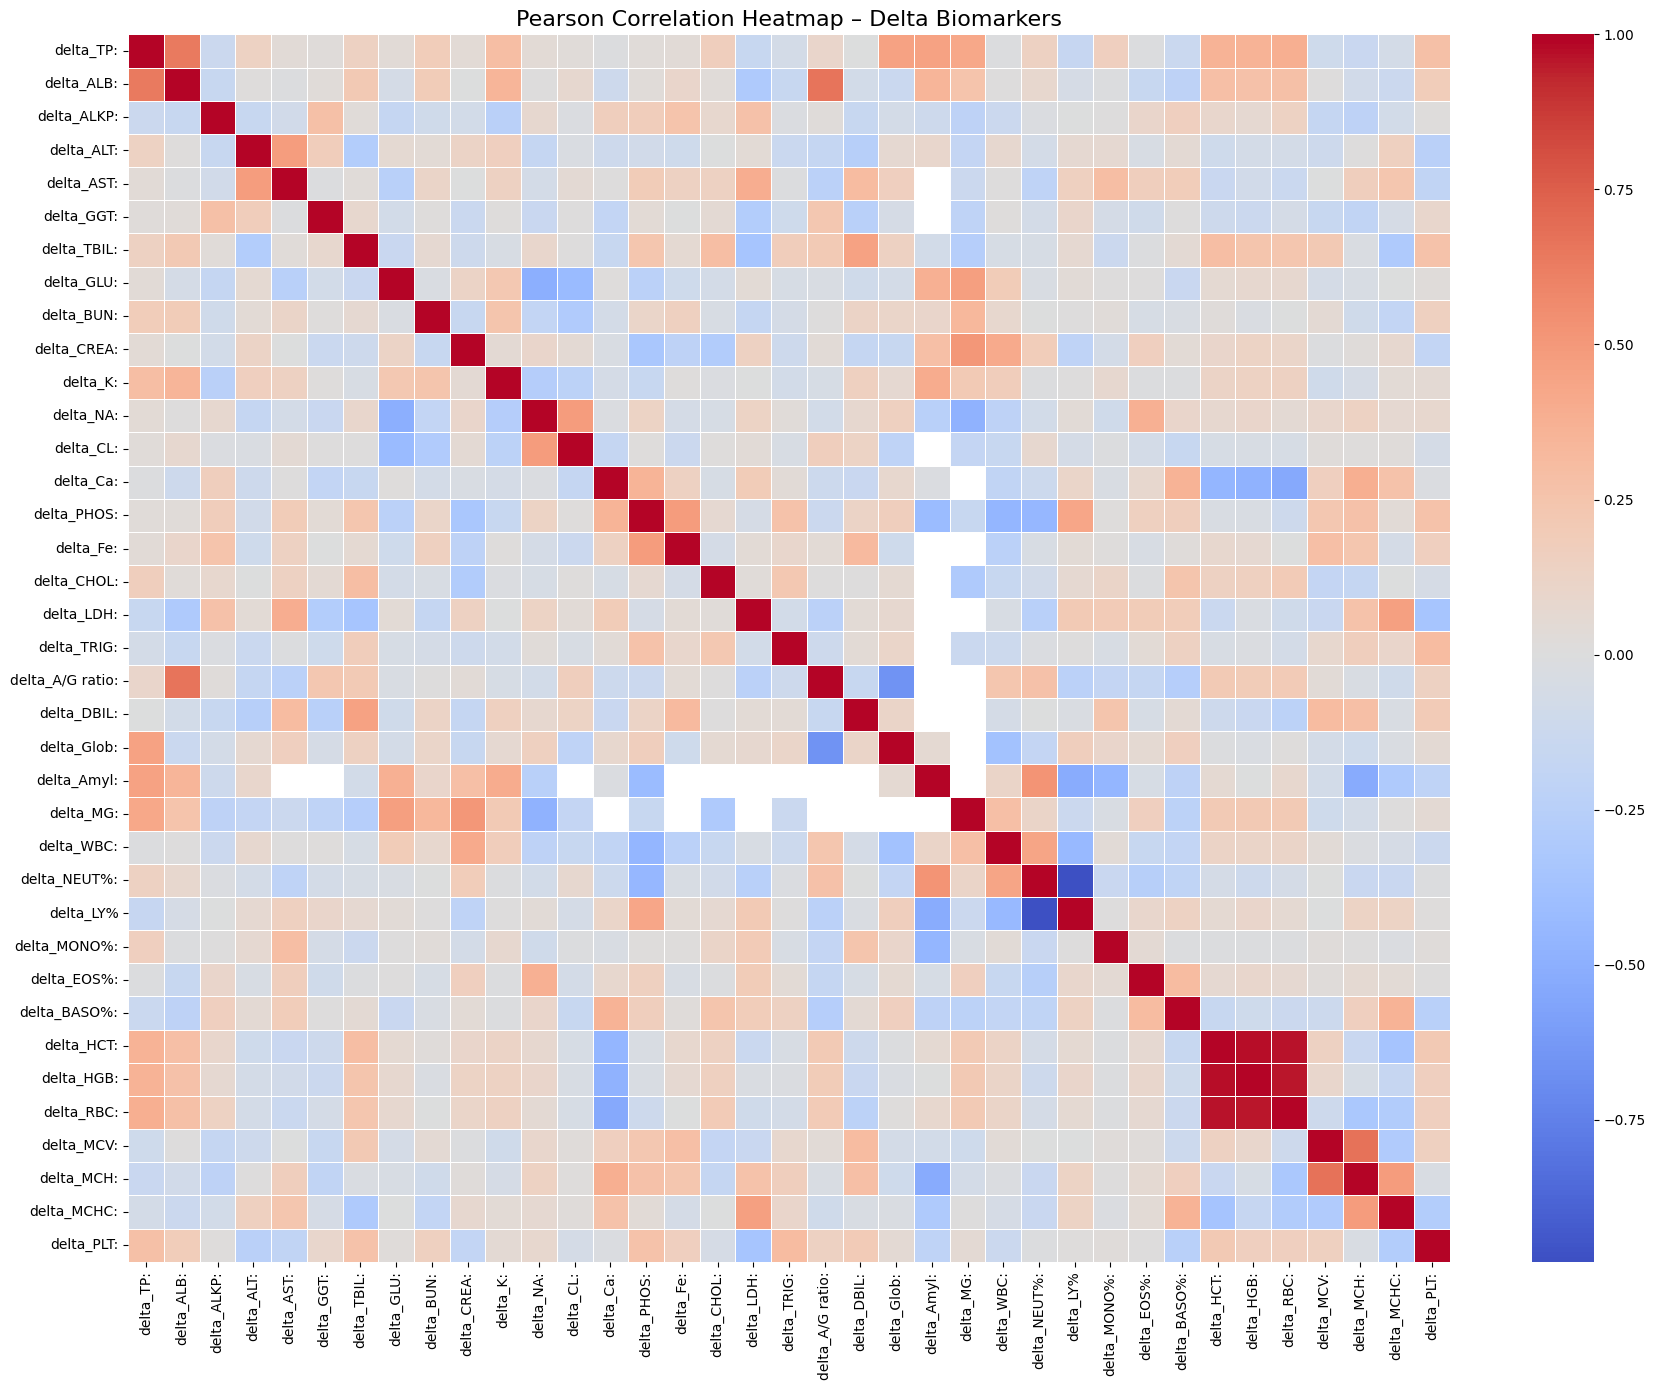

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select delta biomarkers only (excluding _missing)
delta_biomarker_cols_only = [
    col for col in df_delta.columns if col.startswith("delta_") and not col.endswith("_missing")
]

#Filter out columns that are all NaN or constant
df_corr_input = df_delta[delta_biomarker_cols_only].copy()
df_corr_input = df_corr_input.loc[:, df_corr_input.nunique(dropna=True) > 1]  # remove constant columns
df_corr_input = df_corr_input.dropna(axis=1, how='all')  # remove all-NaN columns

# Compute correlation
corr_matrix = df_corr_input.corr(method='pearson')

#Plot
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Pearson Correlation Heatmap – Delta Biomarkers", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("correlation_heatmap_delta.png", dpi=300)  # Save to file
plt.show()


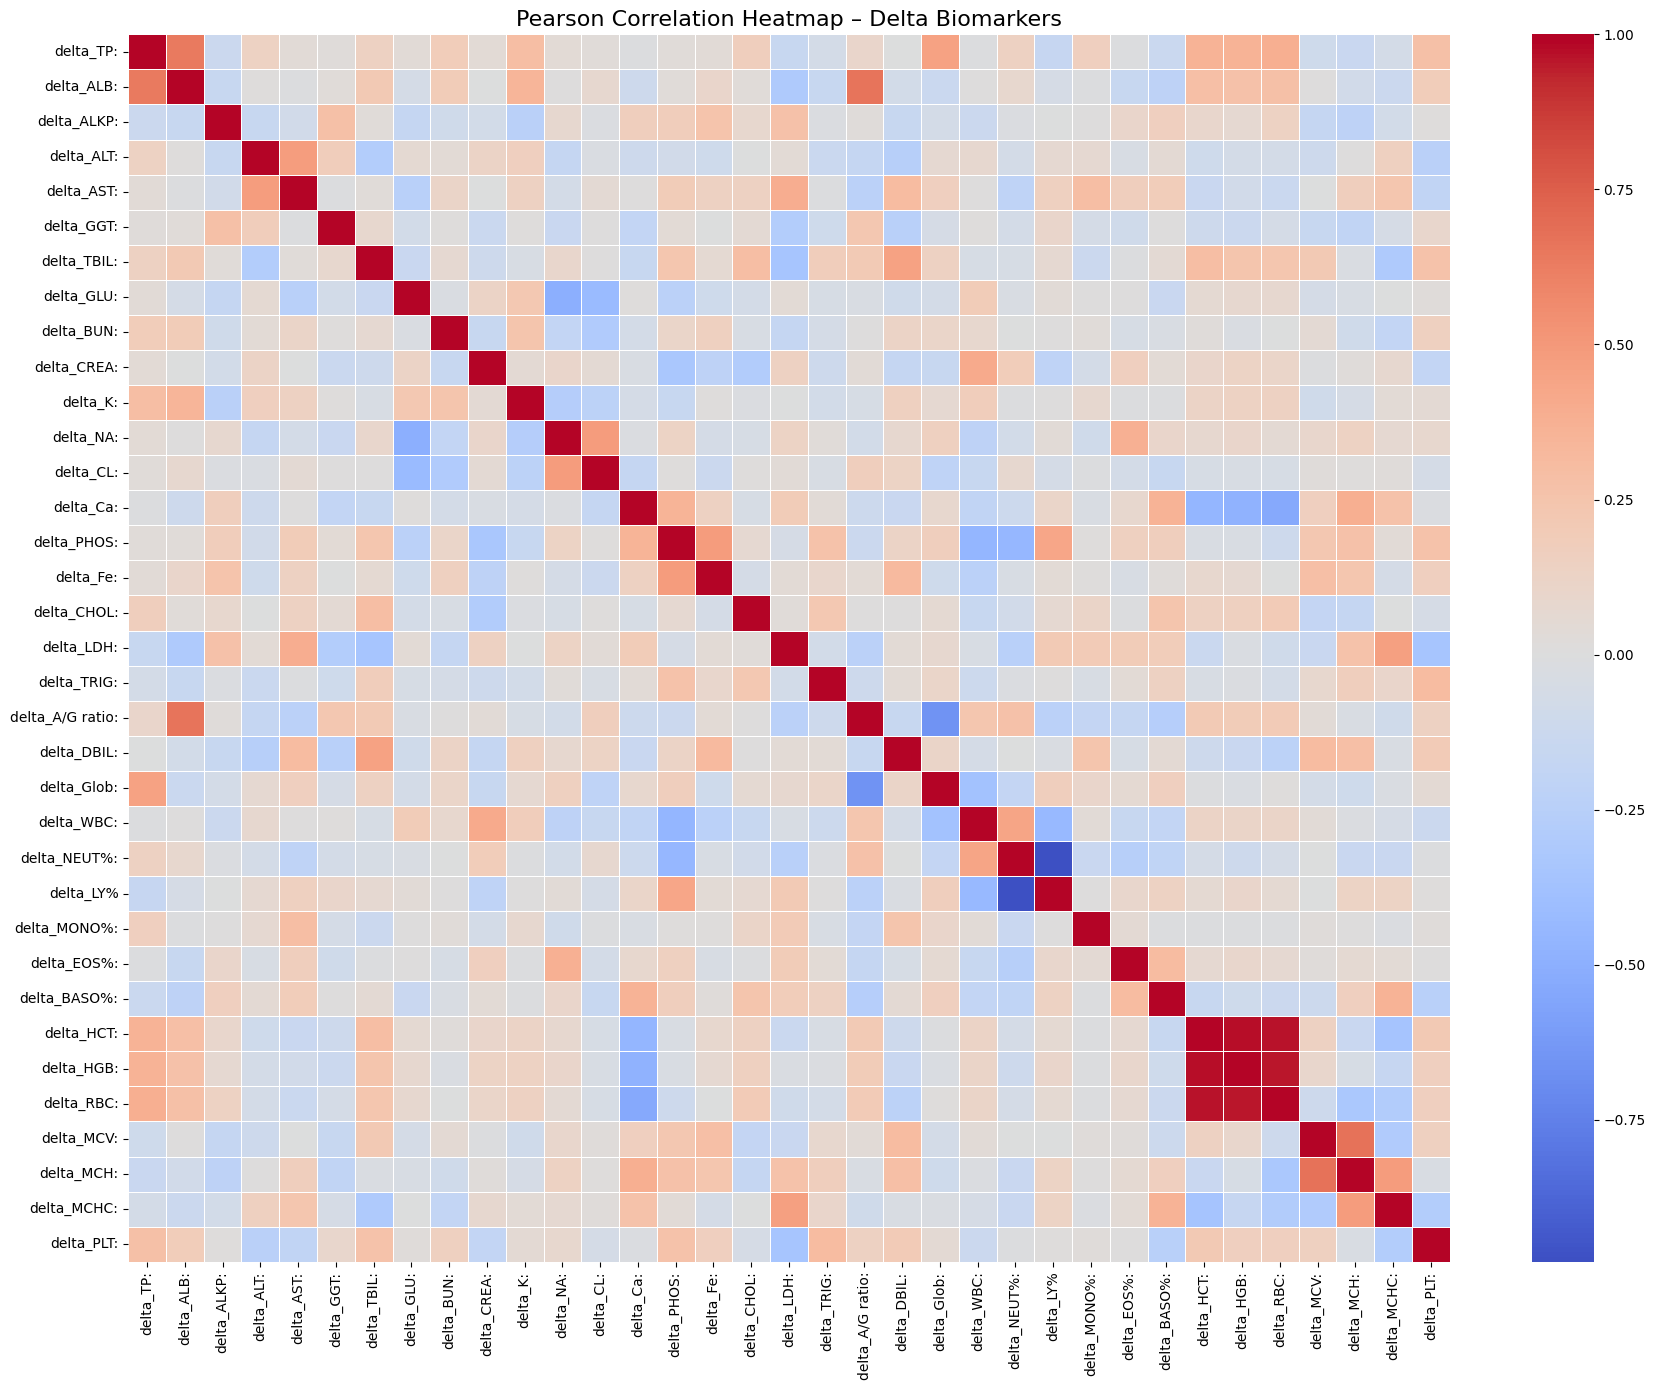

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Filter delta biomarker columns (excluding _missing and specific biomarkers)
exclude_cols = ['delta_Amyl:', 'delta_MG:'] #Amyl and MG
delta_biomarker_cols_only = [
    col for col in df_delta.columns
    if col.startswith("delta_") and not col.endswith("_missing") and col not in exclude_cols
]

#Drop constant or all-NaN columns
df_corr_input = df_delta[delta_biomarker_cols_only].copy()
df_corr_input = df_corr_input.loc[:, df_corr_input.nunique(dropna=True) > 1]
df_corr_input = df_corr_input.dropna(axis=1, how='all')

#Compute correlation
corr_matrix = df_corr_input.corr(method='pearson')

# Plot
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Pearson Correlation Heatmap – Delta Biomarkers", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
save_and_show_plot("correlation_heatmap_pearson")



Figure: Pearson correlation heatmap among delta biomarkers. High correlation coefficients (positive or negative) suggest interdependent biomarker changes potentially co-varying with physiological or pathological processes.

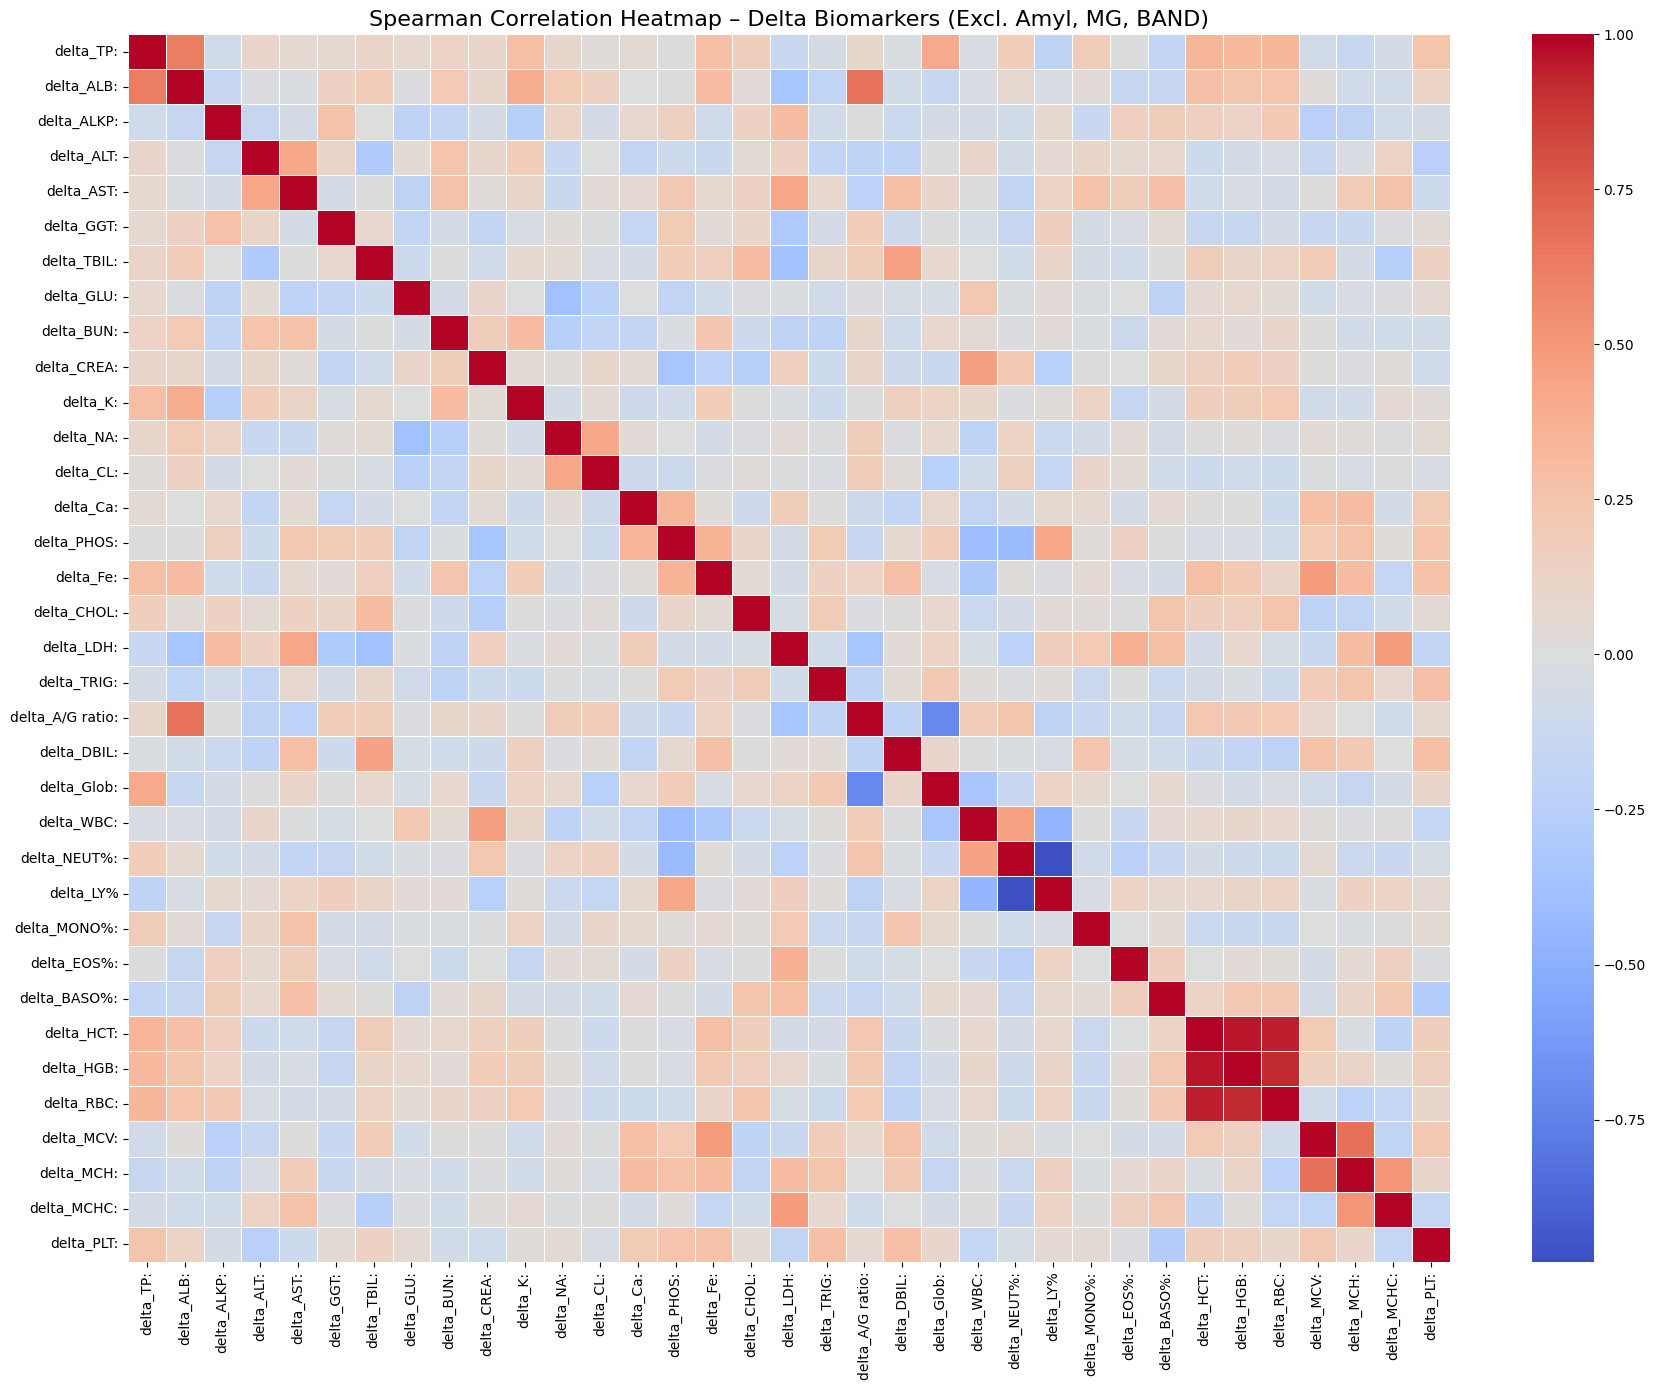

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for delta biomarker columns (excluding _missing, Amyl, MG)
delta_biomarker_cols_spearman = [
    col for col in df_delta.columns
    if col.startswith("delta_")
    and not col.endswith("_missing")
    and "Amyl" not in col
    and "MG:" not in col
    and "BAND%:" not in col
]

# Drop columns with all NaNs
df_spearman_input = df_delta[delta_biomarker_cols_spearman].dropna(axis=1, how='all')

# Compute Spearman correlation
spearman_corr_matrix = df_spearman_input.corr(method='spearman')

# Plot Spearman heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(spearman_corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Spearman Correlation Heatmap – Delta Biomarkers (Excl. Amyl, MG, BAND)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
save_and_show_plot("correlation_heatmap_spearman")



Figure: Spearman rank-based correlation heatmap of delta biomarkers. Unlike Pearson, this method captures monotonic but non-linear relationships and is robust to outliers, helping identify non-parametric associations among biomarkers.

## Biomarker Correlation Network Graph

We'll construct a network graph using networkx where:
- Nodes = biomarkers
- Edges = correlation ≥ threshold (e.g., |r| ≥ 0.6)
- Green edges = positive correlation
- Red edges = negative correlation

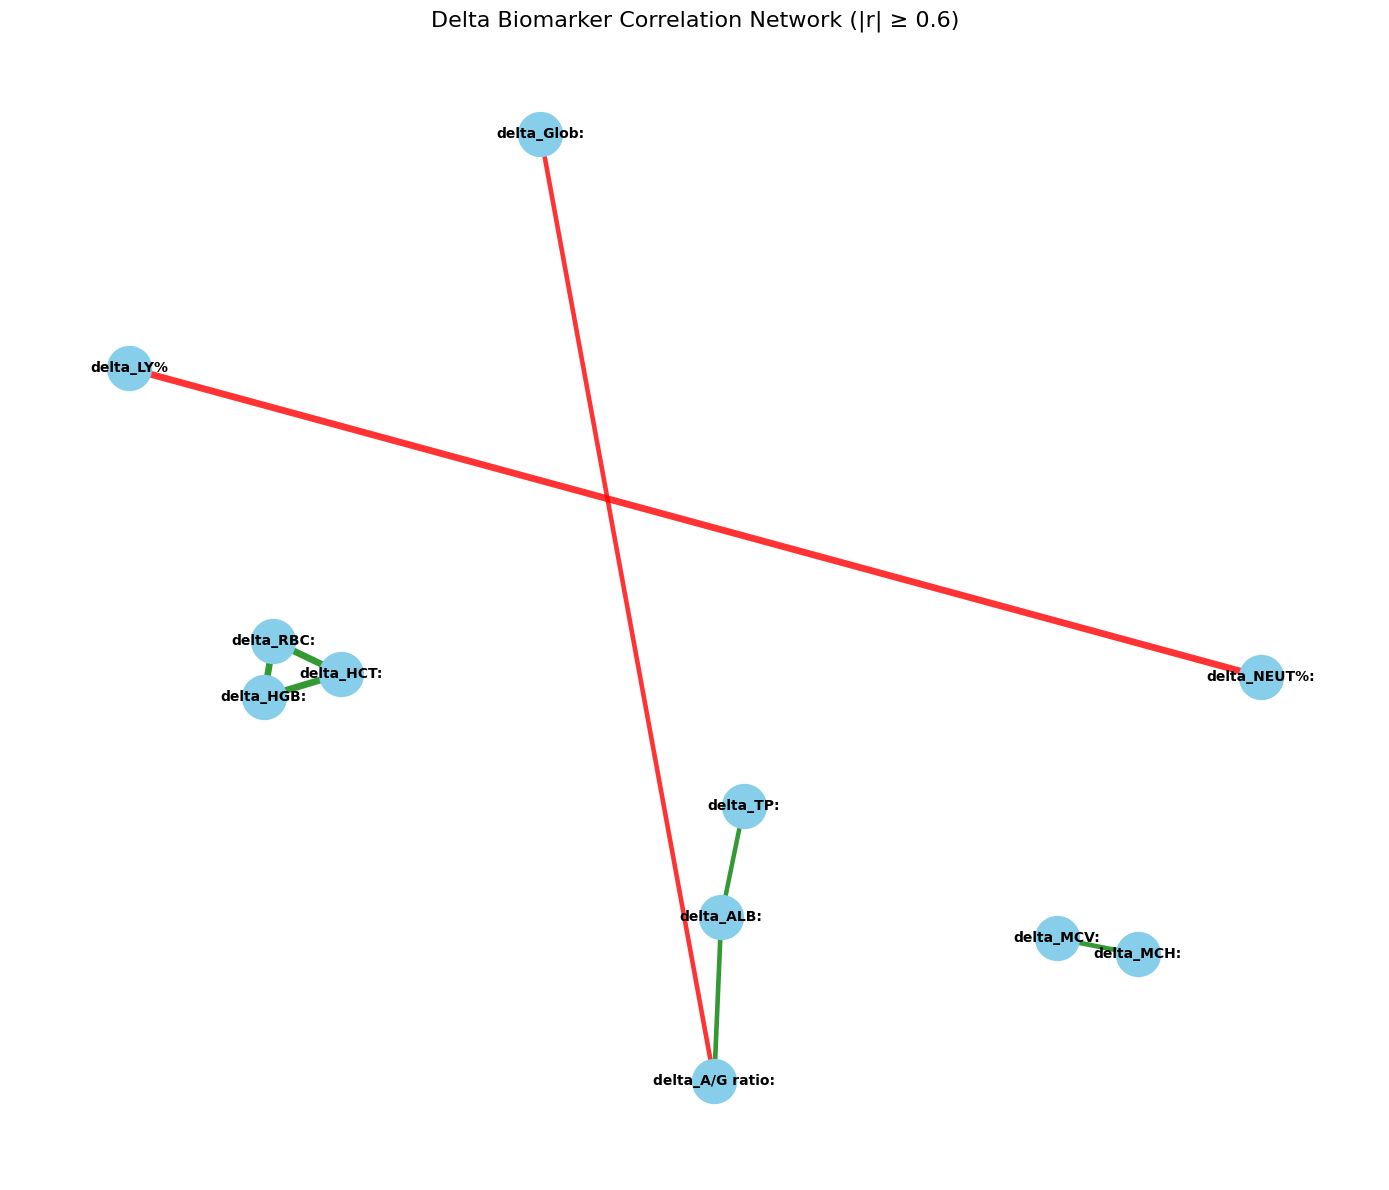

In [ ]:
import networkx as nx
import numpy as np

# Threshold for strong correlation
threshold = 0.6

# Extract upper triangle to avoid duplicates
strong_corrs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
strong_corrs = strong_corrs.stack().reset_index()
strong_corrs.columns = ['Biomarker 1', 'Biomarker 2', 'Correlation']
strong_corrs = strong_corrs[strong_corrs['Correlation'].abs() >= threshold]

# Build graph
G = nx.Graph()

for _, row in strong_corrs.iterrows():
    G.add_edge(row['Biomarker 1'], row['Biomarker 2'], weight=row['Correlation'])

# Layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes
plt.figure(figsize=(14, 12))
edges = G.edges(data=True)
edge_colors = ['green' if d['weight'] > 0 else 'red' for (_, _, d) in edges]
edge_widths = [abs(d['weight']) * 5 for (_, _, d) in edges]

nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Delta Biomarker Correlation Network (|r| ≥ 0.6)", fontsize=16)
plt.axis('off')
save_and_show_plot("network_graph_correlated_biomarkers")



Figure: Network graph showing significant correlations (|r| ≥ 0.6) between delta biomarkers. Edges indicate strong positive (green) or negative (red) relationships, offering an intuitive overview of co-regulated physiological pathways.

## Predictive Modeling of Drinking Category
### Use delta biomarkers (+ optional metadata and missing flags) to classify drinking_category.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np
import pandas as pd

#Setup input feature sets
delta_features = [col for col in df_delta.columns if col.startswith("delta_")]
meta_features = ['mky_gender', 'Species', 'mky_weight']
df_encoded_meta = pd.get_dummies(df_delta[meta_features], drop_first=True)

# Feature sets
X_delta_only = df_delta[delta_features].copy()
X_delta_plus_meta = pd.concat([X_delta_only, df_encoded_meta], axis=1)
y = df_delta["drinking_category"]

# Encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)

#Split strategy (with class coverage guarantee)
def stratified_split_with_class_coverage(X, y, test_size=0.2, random_state=42, max_retries=100):
    for attempt in range(max_retries):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state + attempt
        )
        if len(set(y)) == len(set(y_train)):
            return X_train, X_test, y_train, y_test
    raise ValueError("Failed to stratify with full class coverage.")

# Split both datasets
X_train_delta, X_test_delta, y_train_delta, y_test_delta = stratified_split_with_class_coverage(X_delta_only, y_enc)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = stratified_split_with_class_coverage(X_delta_plus_meta, y_enc)



In [ ]:
#Define param grids
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
xgb_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}


In [ ]:
# Train and evaluate
def evaluate_model(X_train, X_test, y_train, y_test, model_type, param_grid):
    if model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=42, class_weight='balanced')
    else:
        model = xgb.XGBClassifier(objective='multi:softprob', num_class=4, random_state=42,
                                  eval_metric='mlogloss', use_label_encoder=False)

    grid = GridSearchCV(model, param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)

    return {
        'Best_Model': best_model,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_macro': f1_score(y_test, y_pred, average='macro'),
        'ROC_AUC': roc_auc_score(pd.get_dummies(y_test), pd.DataFrame(y_pred_proba), multi_class='ovr'),
        'Classification_Report': classification_report(y_test, y_pred, target_names=le.classes_),
        'Confusion_Matrix': confusion_matrix(y_test, y_pred),
        'Best_Params': grid.best_params_
    }


In [ ]:
# Delta Only
results_rf_delta = evaluate_model(X_train_delta, X_test_delta, y_train_delta, y_test_delta, 'RandomForest', rf_grid)
results_xgb_delta = evaluate_model(X_train_delta, X_test_delta, y_train_delta, y_test_delta, 'XGBoost', xgb_grid)

# Delta + Metadata
results_rf_meta = evaluate_model(X_train_meta, X_test_meta, y_train_meta, y_test_meta, 'RandomForest', rf_grid)
results_xgb_meta = evaluate_model(X_train_meta, X_test_meta, y_train_meta, y_test_meta, 'XGBoost', xgb_grid)


In [ ]:
#Display results summary
def summarize(name, results):
    print(f"\n{name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print(f"F1 Macro: {results['F1_macro']:.4f}")
    print(f"ROC AUC (OvR): {results['ROC_AUC']:.4f}")
    print("\nClassification Report:")
    print(results['Classification_Report'])
    print("\nConfusion Matrix:")
    print(results['Confusion_Matrix'])
    print("\nBest Params:")
    print(results['Best_Params'])

summarize("RF (Delta Only)", results_rf_delta)
summarize("XGB (Delta Only)", results_xgb_delta)
summarize("RF (Delta + Meta)", results_rf_meta)
summarize("XGB (Delta + Meta)", results_xgb_meta)


RF (Delta Only)
Accuracy: 0.44
F1 Macro: 0.3132
ROC AUC (OvR): 0.6295

Classification Report:
              precision    recall  f1-score   support

          BD       0.50      0.20      0.29         5
          HD       0.00      0.00      0.00         3
          LD       0.44      0.70      0.54        10
         VHD       0.43      0.43      0.43         7

    accuracy                           0.44        25
   macro avg       0.34      0.33      0.31        25
weighted avg       0.40      0.44      0.39        25


Confusion Matrix:
[[1 0 3 1]
 [1 0 2 0]
 [0 0 7 3]
 [0 0 4 3]]

Best Params:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

XGB (Delta Only)
Accuracy: 0.40
F1 Macro: 0.2919
ROC AUC (OvR): 0.6040

Classification Report:
              precision    recall  f1-score   support

          BD       0.25      0.20      0.22         5
          HD       0.00      0.00      0.00         3
          LD       0.50      0.60      0.55        10
         VHD  

In [ ]:
# Summarize all results into a table
summary_data = [
    ["RandomForest", "Delta Only", results_rf_delta["Accuracy"], results_rf_delta["F1_macro"], results_rf_delta["ROC_AUC"]],
    ["XGBoost", "Delta Only", results_xgb_delta["Accuracy"], results_xgb_delta["F1_macro"], results_xgb_delta["ROC_AUC"]],
    ["RandomForest", "Delta + Metadata", results_rf_meta["Accuracy"], results_rf_meta["F1_macro"], results_rf_meta["ROC_AUC"]],
    ["XGBoost", "Delta + Metadata", results_xgb_meta["Accuracy"], results_xgb_meta["F1_macro"], results_xgb_meta["ROC_AUC"]],
]

model_df = pd.DataFrame(summary_data, columns=["Model", "Features", "Accuracy", "F1 Macro", "ROC AUC"])
#dfi.export(model_df, "figures/classification_summary.png")


##Results Summary: Delta-Only vs Delta+Metadata Models

We compared model performance using Random Forest (RF) and XGBoost (XGB) across two feature sets: delta biomarkers only and delta biomarkers combined with metadata.

**Delta Biomarkers Only:**
- RF achieved **accuracy = 0.44**, **F1_macro = 0.31**, **ROC AUC = 0.63**
- XGB yielded slightly lower results with **accuracy = 0.40**, **F1_macro = 0.29**, **ROC AUC = 0.60**
- Models struggled to classify rare classes (e.g., HD), likely due to class imbalance.

**Delta + Metadata:**
- RF improved to **accuracy = 0.56**, **F1_macro = 0.41**, **ROC AUC = 0.66**
- XGB performed best overall: **accuracy = 0.60**, **F1_macro = 0.45**, **ROC AUC = 0.66**
- The inclusion of metadata (e.g., gender, weight, species) provided clear performance gains, especially in classifying LD and VHD.

These results suggest that behavioral and biological metadata offer valuable context that complements delta biomarker shifts in modeling drinking category.


## SHAP Visualization for best model

In [ ]:
best_model_xgb_meta = results_xgb_meta['Best_Model']
X_train_used = X_train_meta


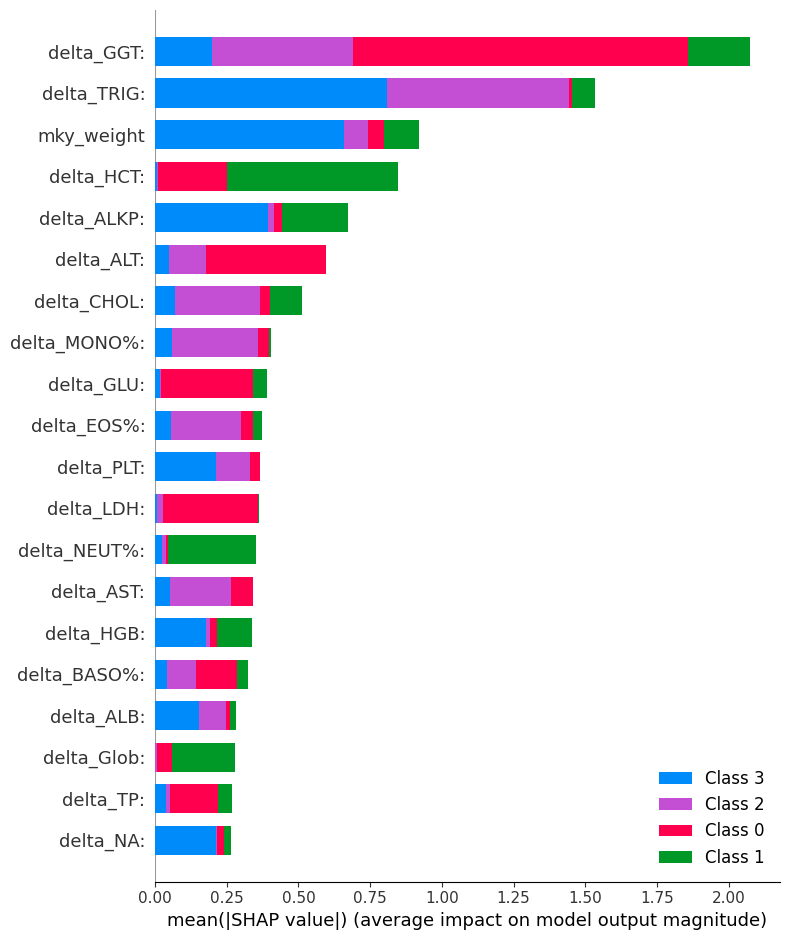

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_model_xgb_meta)
shap_values = explainer.shap_values(X_train_used)

# Bar plot: Feature importance
shap.summary_plot(shap_values, X_train_used, plot_type="bar", show=True)
plt.savefig("figures/shap_summary_bar.png", dpi=300)
plt.show()



Caption (SHAP Bar):Figure: Global feature importance summary using SHAP values for the XGBoost model. Delta biomarkers and metadata are ranked by their average impact on prediction decisions across all samples.

<Figure size 640x480 with 0 Axes>

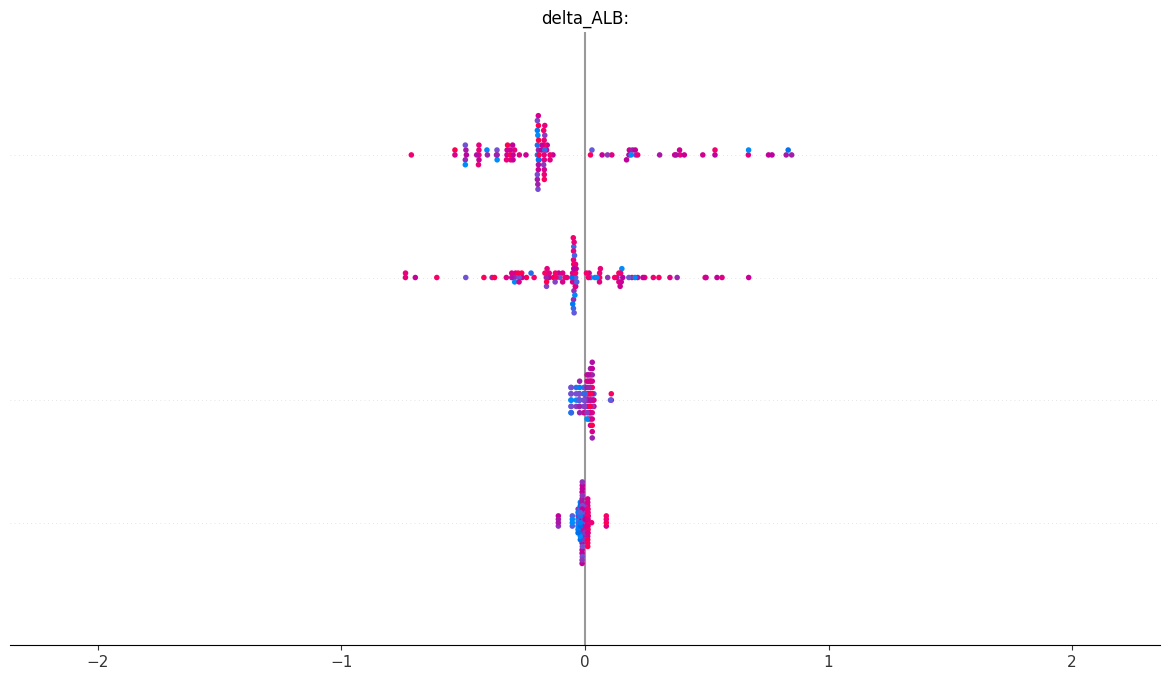

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot summary
shap.summary_plot(shap_values, X_train_used, show=True)
plt.savefig("figures/shap_summary_dot_avg.png", dpi=300)
plt.show()

Caption (SHAP Dot):
Figure: SHAP value distribution per feature. Each dot reflects the influence of a feature for one individual. Feature values are color-coded, revealing patterns such as directionality and spread of effect.

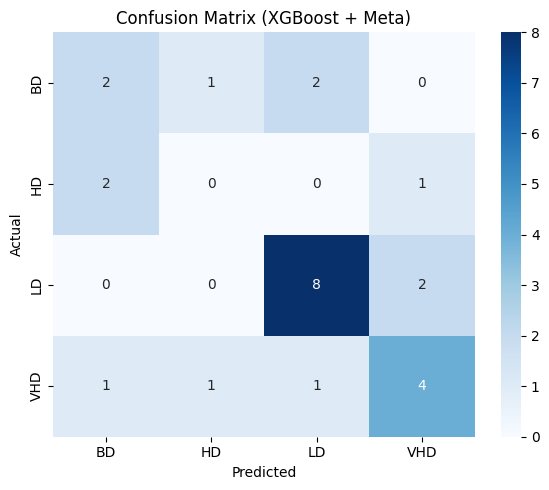

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_meta, best_model_xgb_meta.predict(X_test_meta))
labels = le.inverse_transform(np.arange(len(cm)))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (XGBoost + Meta)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
save_and_show_plot("confusion_matrix_xgb_meta")



Figure: Confusion matrix for the XGBoost model trained on delta biomarkers and metadata. Cell counts represent the frequency of true vs. predicted drinking categories. Misclassification is most common between adjacent consumption levels, highlighting challenge in class separation.

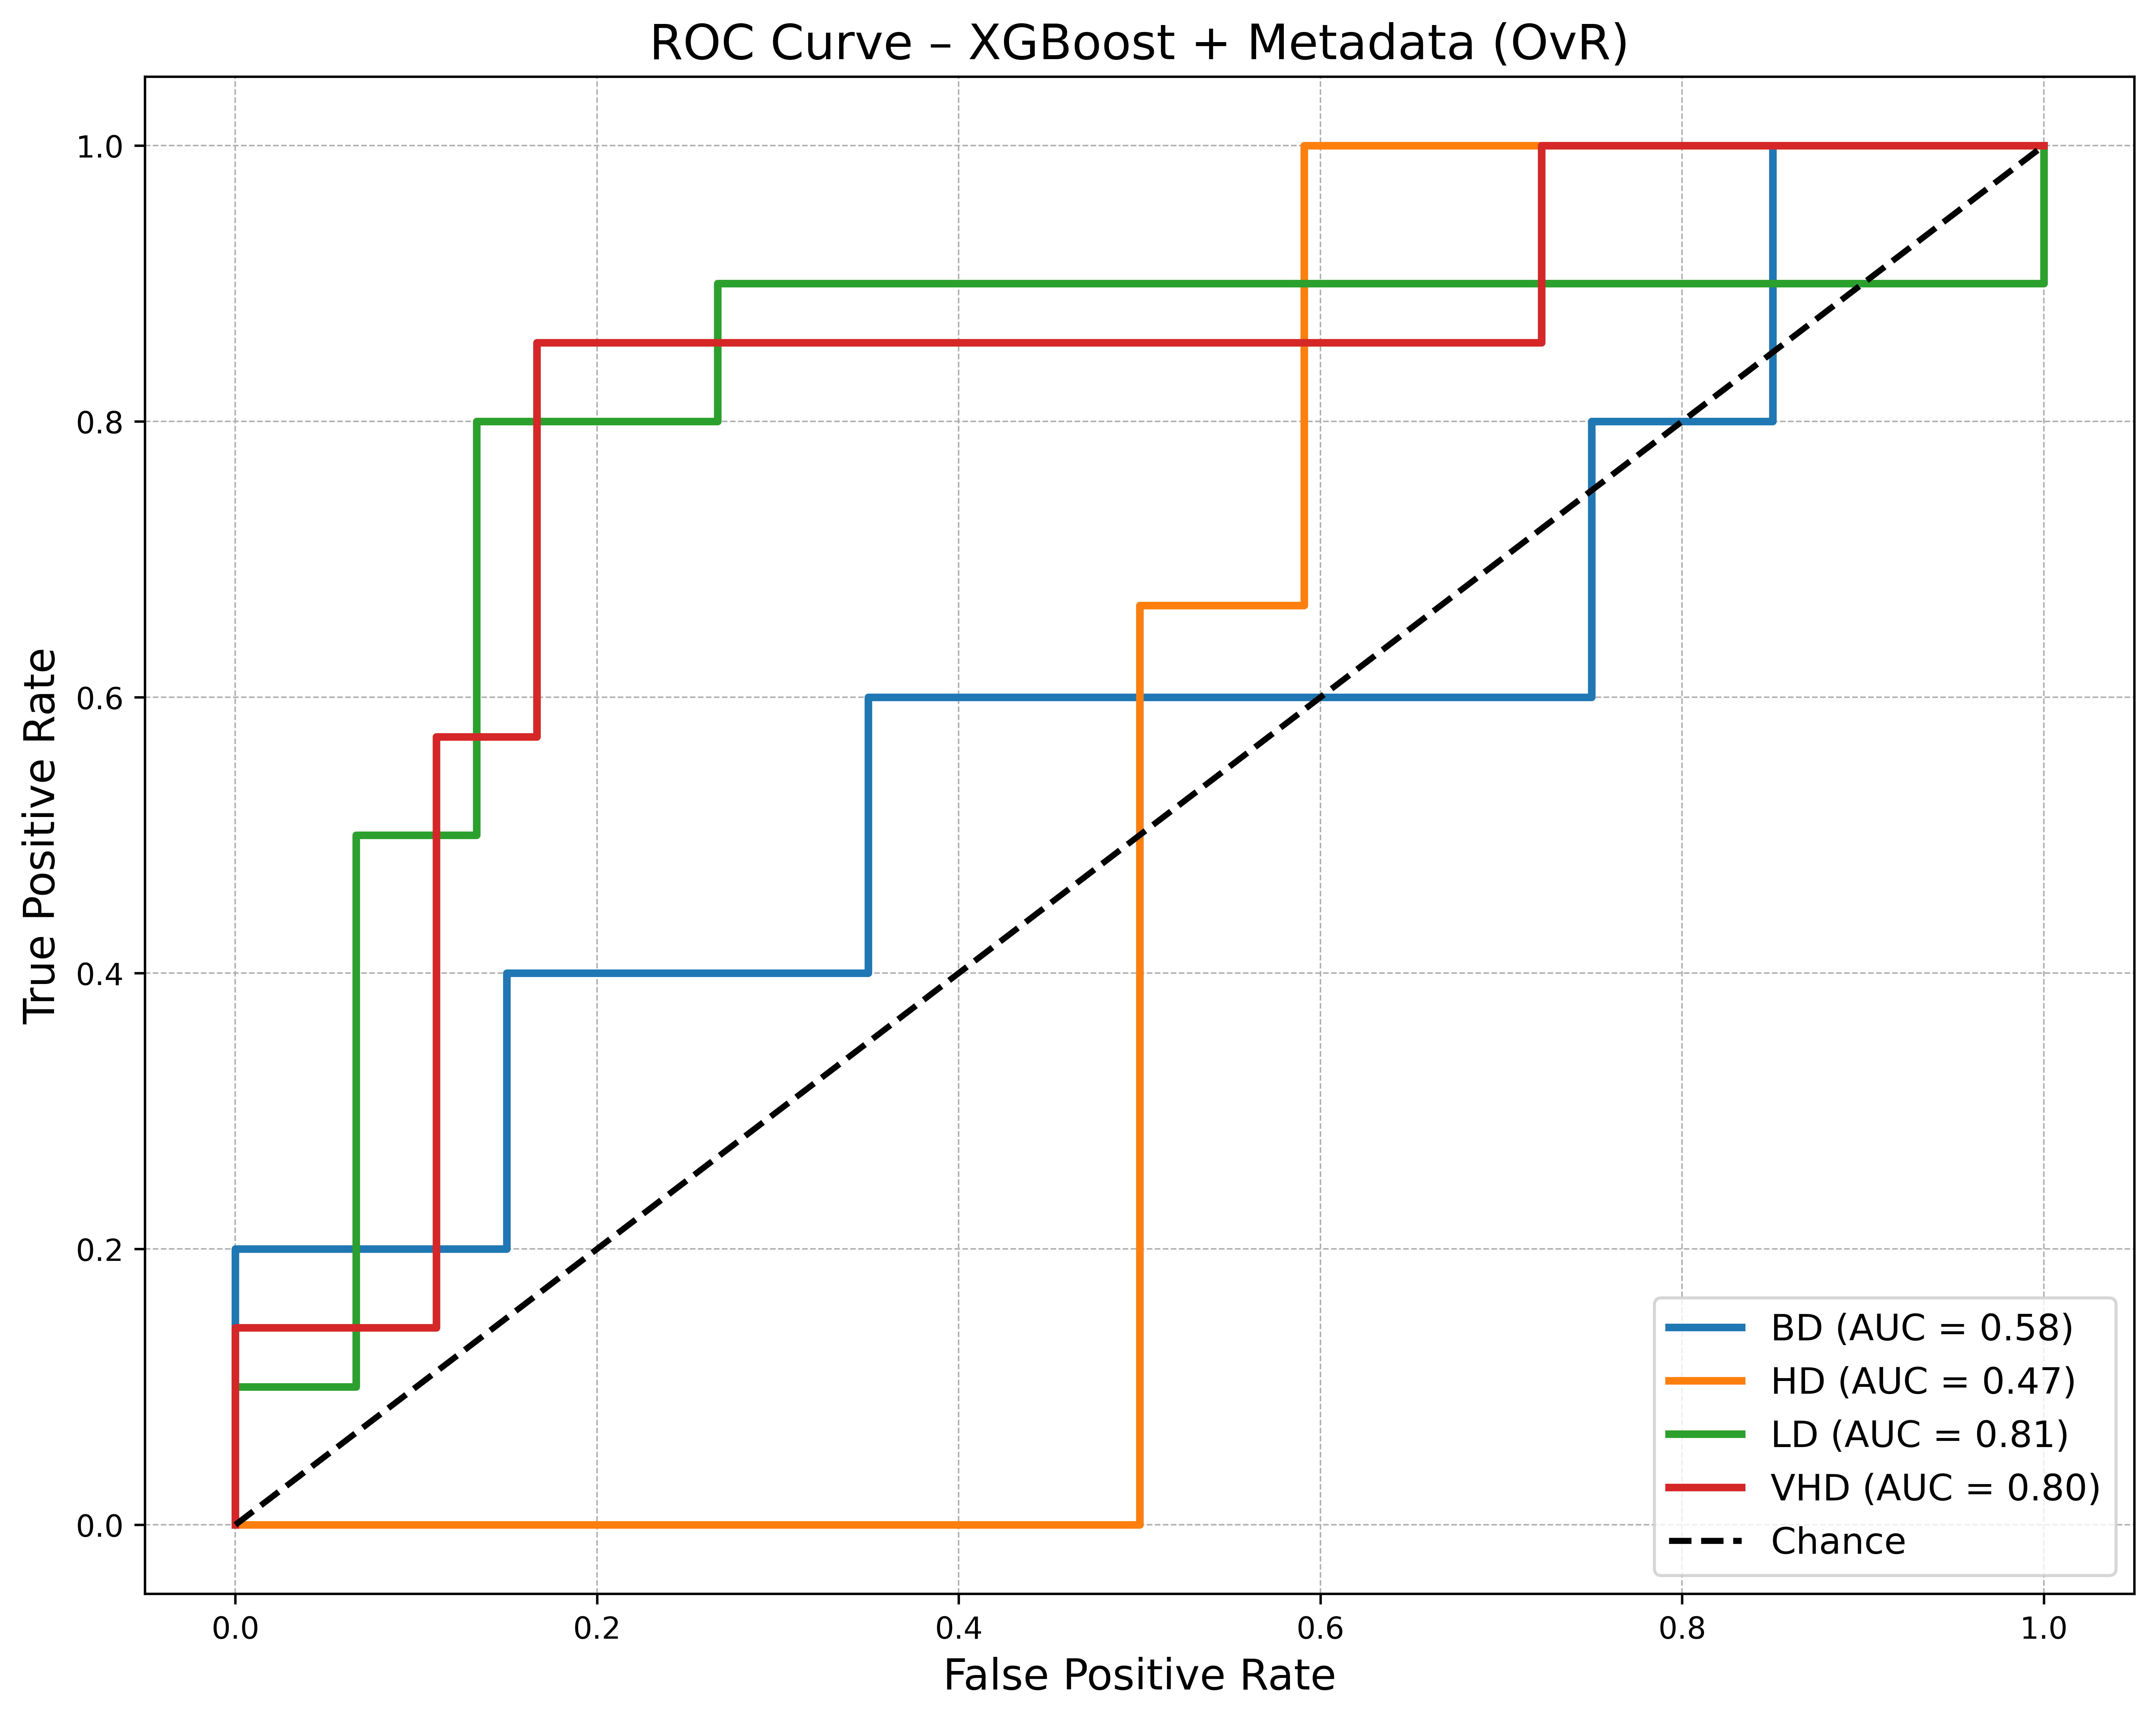

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_meta, classes=le.transform(le.classes_))
y_score = best_model_xgb_meta.predict_proba(X_test_meta)

plt.figure(figsize=(10, 8), dpi=600)  # Larger and higher-res
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2.5, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve – XGBoost + Metadata (OvR)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
save_and_show_plot("roc_curve_xgb_meta_UPDATED")



Figure: Receiver Operating Characteristic (ROC) curves for XGBoost model using delta biomarkers and metadata.
One-vs-rest ROC curves are shown for each drinking category, displaying the trade-off between sensitivity (true positive rate) and specificity (1 − false positive rate). The area under the curve (AUC) quantifies the model's discriminative performance for each class. An AUC of 1.0 indicates perfect classification, while an AUC of 0.5 reflects chance-level performance. The dashed line represents the random classifier baseline. This visualization demonstrates the model’s variable predictive strength across classes, with stronger separability in categories such as LD and VHD compared to HD, which likely suffers from limited sample representation.

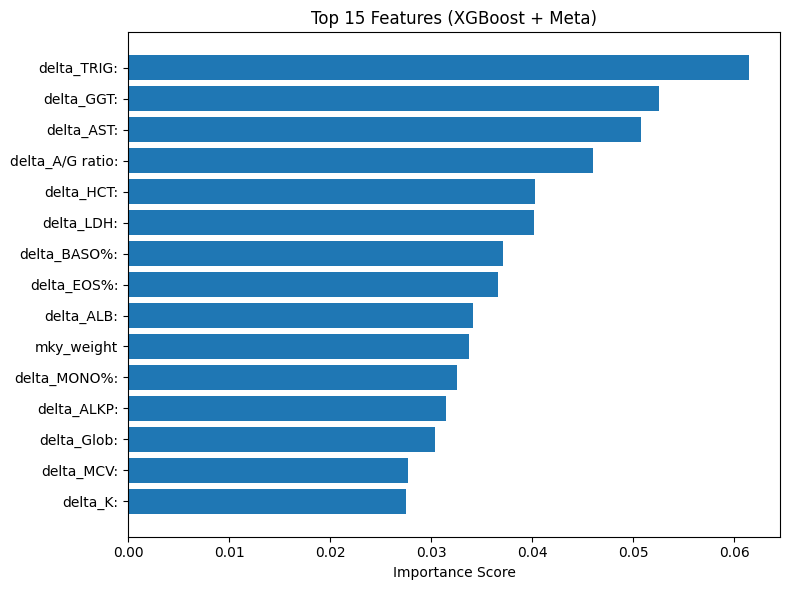

In [ ]:
import pandas as pd

importances = best_model_xgb_meta.feature_importances_
feature_names = X_train_meta.columns
top_features_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8, 6))
plt.barh(top_features_df["Feature"], top_features_df["Importance"])
plt.xlabel("Importance Score")
plt.title("Top 15 Features (XGBoost + Meta)")
plt.gca().invert_yaxis()
save_and_show_plot("feature_importance_xgb_meta")

Figure: Top 15 most important features used by the XGBoost model with metadata. Importance reflects each feature's contribution to classification performance. Both delta biomarkers and metadata variables (e.g., weight, gender) emerge as influential predictors.

## Analyze how drinking categories are influencing the biomarkers

### Apply One-Way ANOVA and Kruskal-Wallis across all delta biomarkers grouped by drinking category. This will help assess if drinking status influences biomarker changes.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, kruskal

# Define delta biomarker columns (ensure you're using df_delta)
delta_biomarker_cols = [col for col in df_delta.columns if col.startswith('delta_')]
group_col = 'drinking_category'

anova_results = []
kruskal_results = []

# Iterate through each delta biomarker
for biomarker in delta_biomarker_cols:
    data = df_delta[[group_col, biomarker]].dropna()

    # Group data by drinking category
    groups = [group[biomarker].values for name, group in data.groupby(group_col)]

    # Perform ANOVA (parametric)
    try:
        anova_stat, anova_p = f_oneway(*groups)
    except Exception:
        anova_stat, anova_p = np.nan, np.nan

    # Perform Kruskal-Wallis (non-parametric)
    try:
        kw_stat, kw_p = kruskal(*groups)
    except Exception:
        kw_stat, kw_p = np.nan, np.nan

    # Store results
    anova_results.append({
        "Biomarker": biomarker,
        "ANOVA_F": anova_stat,
        "ANOVA_p": anova_p,
        "Significant_ANOVA": "p < 0.05" if anova_p < 0.05 else ""
    })
    kruskal_results.append({
        "Biomarker": biomarker,
        "Kruskal_H": kw_stat,
        "Kruskal_p": kw_p,
        "Significant_KW": "p < 0.05" if kw_p < 0.05 else ""
    })

# Convert to DataFrames
df_anova = pd.DataFrame(anova_results).sort_values("ANOVA_p")
df_kruskal = pd.DataFrame(kruskal_results).sort_values("Kruskal_p")

# View top results (optional)
print("Top Delta Biomarkers by Kruskal-Wallis (lowest p-values):")
print(df_kruskal.head(15))
print("\nTop Delta Biomarkers by ANOVA (lowest p-values):")
print(df_anova.head(15))

# Save ANOVA top biomarkers
df_anova_top = df_anova[df_anova['ANOVA_p'] < 0.05].head(15)
#dfi.export(df_anova_top, 'figures/anova_top_biomarkers.png')


Top Delta Biomarkers by Kruskal-Wallis (lowest p-values):
           Biomarker  Kruskal_H  Kruskal_p Significant_KW
5         delta_GGT:  26.510865   0.000007       p < 0.05
1         delta_ALB:  17.841137   0.000474       p < 0.05
33        delta_RBC:  16.202159   0.001031       p < 0.05
18       delta_TRIG:  15.155354   0.001689       p < 0.05
31        delta_HCT:  12.519436   0.005800       p < 0.05
32        delta_HGB:  11.701895   0.008477       p < 0.05
17        delta_LDH:  11.078220   0.011310       p < 0.05
10          delta_K:  11.054109   0.011437       p < 0.05
19  delta_A/G ratio:   9.809944   0.020253       p < 0.05
0          delta_TP:   8.881558   0.030908       p < 0.05
35        delta_MCH:   8.725133   0.033178       p < 0.05
48  delta_K:_missing   8.401639   0.038401       p < 0.05
23         delta_MG:   8.294349   0.040304       p < 0.05
9        delta_CREA:   6.967033   0.072956               
28      delta_MONO%:   6.321346   0.096981               

Top Delta Bio

## Statistical Comparison of Delta Biomarkers by Drinking Category

To investigate whether changes in biomarker levels (delta values) differ significantly across drinking categories, we applied both:
- Kruskal-Wallis Test (non-parametric; robust to non-normality)
- One-Way ANOVA (parametric; assumes normality and equal variances)

The Kruskal-Wallis test revealed several delta biomarkers with significant differences (p < 0.05) across drinking groups:
- delta_GGT (H = 26.51, p = 7e-6)— strongest signal
- delta_ALB, delta_RBC, delta_TRIG, delta_HCT, delta_HGB, and delta_K also showed statistically significant variation.
- These span across liver, hematological, and electrolyte function markers.

Notably, delta_GGT is consistent with expected biological relevance: GGT is a liver enzyme commonly elevated in chronic alcohol use, supporting its potential as a predictive or diagnostic marker.

The ANOVA results largely agreed with Kruskal-Wallis, though fewer biomarkers reached significance. This may reflect mild deviations from normality, reinforcing the importance of non-parametric tests in this context.

### Download plots

In [ ]:
import shutil
shutil.make_archive("matrr_figures", 'zip', "figures")

'/content/matrr_figures.zip'

In [ ]:
from google.colab import files
files.download("/content/matrr_figures.zip")


# Reviewing Master Biomarker Dataset

## Load and Prepare the Master Dataset

In [ ]:
# Step 1: Load Master Dataset
import pandas as pd

master_path = "https://github.com/arogelg/MATRR-Capstone-Project/blob/main/csv%20files/10_23_2024_MASTER_MATRR_AllCohorts_Blood_hematology_biochemistry.csv?raw=true"
df_master = pd.read_csv(master_path)

# Preview columns and structure
print(df_master.shape)
print(df_master.columns.tolist())
df_master.head()


(1047, 46)
['Species', 'Cohort', 'MATRR ID', 'Date of BC', 'Timepoint', 'State', 'TP:', 'ALB:', 'ALKP:', 'ALT:', 'AST:', 'GGT:', 'TBIL:', 'GLU:', 'BUN:', 'CREA:', 'K:', 'NA:', 'CL:', 'Ca:', 'PHOS:', 'Fe:', 'CHOL:', 'LDH:', 'TRIG:', 'A/G ratio:', 'DBIL:', 'Glob:', 'Amyl:', 'MG:', 'WBC:', 'NEUT%:', 'BAND%:', 'LY%', 'MONO%:', 'EOS%:', 'BASO%:', 'HCT:', 'HGB:', 'RBC:', 'MCV:', 'MCH:', 'MCHC:', 'PLT:', 'Unnamed: 44', 'Unnamed: 45']


Species Cohort MATRR ID  Date of BC      Timepoint    State  TP:  ALB:  \
0    cyno      2    10016   8/17/2005  pre-induction  sedated  7.4   NaN   
1    cyno      2    10016    2/6/2006  H2O induction    awake  NaN   NaN   
2    cyno      2    10016   3/27/2006  H2O induction  sedated    7   4.2   
3    cyno      2    10016  10/26/2006  open access 1  sedated  7.9   4.6   
4    cyno      2    10016   4/18/2007  open access 2  sedated    7   4.2   

   ALKP:  ALT:  ...  BASO%:  HCT:  HGB:  RBC:  MCV:  MCH:  MCHC:   PLT:  \
0    NaN   NaN  ...     0.7  43.5  14.3  6.05  72.0  23.6   32.9  426.0   
1    NaN   NaN  ...     0.7  44.1  14.1  5.90  75.0  23.9   32.0  167.0   
2  167.0  45.0  ...     0.8  42.8  13.9  5.73  75.0  24.3   32.5  378.0   
3   84.0  37.0  ...     0.5  42.5  13.7  5.66  75.0  24.2   32.2  446.0   
4  138.0  25.0  ...     0.9  42.9  13.5  5.63  76.0  24.0   31.5  214.0   

   Unnamed: 44        Unnamed: 45  
0          NaN  LY% = Lymphocytes  
1          NaN                NaN  
2          NaN                NaN  
3          NaN                NaN  
4          NaN                NaN  

[5 rows x 46 columns]

## Load before and after dataset to extract meta features

In [ ]:
#load in before and after dataset
df_ba = pd.read_csv("https://github.com/arogelg/MATRR-Capstone-Project/blob/main/csv%20files/Before_After.csv?raw=true")


## Merge Drinking Category into Master Dataset

In [ ]:
# Standardize column names (strip spaces, make consistent)
df_master.columns = df_master.columns.str.strip().str.replace(" ", "_")
df_ba.columns = df_ba.columns.str.strip().str.replace(" ", "_")


In [ ]:
# --- Standardize and prepare keys ---
for df in [df_ba, df_master]:
    df.columns = df.columns.str.strip().str.replace(" ", "_")
    df['MATRR_ID'] = df['MATRR_ID'].astype(str)

# --- Extract and merge relevant info ---
# Unique monkey-level info from before/after dataset
# Add mky_gender to the monkey-level metadata
monkey_meta = df_ba[['MATRR_ID', 'mky_weight', 'drinking_category', 'mky_gender']].drop_duplicates()

# Merge into master
df_master = df_master.merge(monkey_meta, on='MATRR_ID', how='left')


## Summary Table – Monkey Distribution

In [ ]:
# Condensed monkey overview: Species x Gender x Drinking Category
overview_table = df_master.groupby(['Species', 'mky_gender', 'drinking_category']).agg(
    Monkey_Count=('MATRR_ID', 'nunique'),
    Avg_Weight=('mky_weight', 'mean')
).reset_index()

# Round weight for readability
overview_table['Avg_Weight'] = overview_table['Avg_Weight'].round(2)

# Sort for presentation
overview_table = overview_table.sort_values(['Species', 'mky_gender', 'drinking_category'])

# Display in notebook
overview_table.style.set_caption("Overview of Monkeys by Species, Gender, and Drinking Category")


## Prep data for boxplots

In [ ]:
# Create biomarker list by excluding metadata
exclude_cols = ['MATRR_ID', 'Species', 'Cohort', 'phase', 'drinking_category', 'Weight', 'mky_gender', 'State']
biomarker_cols = [col for col in df_ba.columns if col not in exclude_cols and df_ba[col].dtype in ['float64', 'int64']]

# Melt the biomarker data for boxplotting
df_melted = df_ba.melt(
    id_vars=['MATRR_ID', 'phase', 'drinking_category', 'Species', 'mky_gender'],
    value_vars=biomarker_cols,
    var_name='Biomarker',
    value_name='Value'
)


In [ ]:
df_melted.head()


MATRR_ID   phase drinking_category Species mky_gender Biomarker  Value
0    10016  before                LD    cyno          M       TP:    7.0
1    10016   after                LD    cyno          M       TP:    7.9
2    10018  before                LD    cyno          M       TP:    6.6
3    10018   after                LD    cyno          M       TP:    7.3
4    10019  before                LD    cyno          M       TP:    6.5

In [ ]:
custom_palette = {
    'VHD': 'red',
    'LD': 'green',
    'HD': 'orange',
    'BD': 'blue'
}

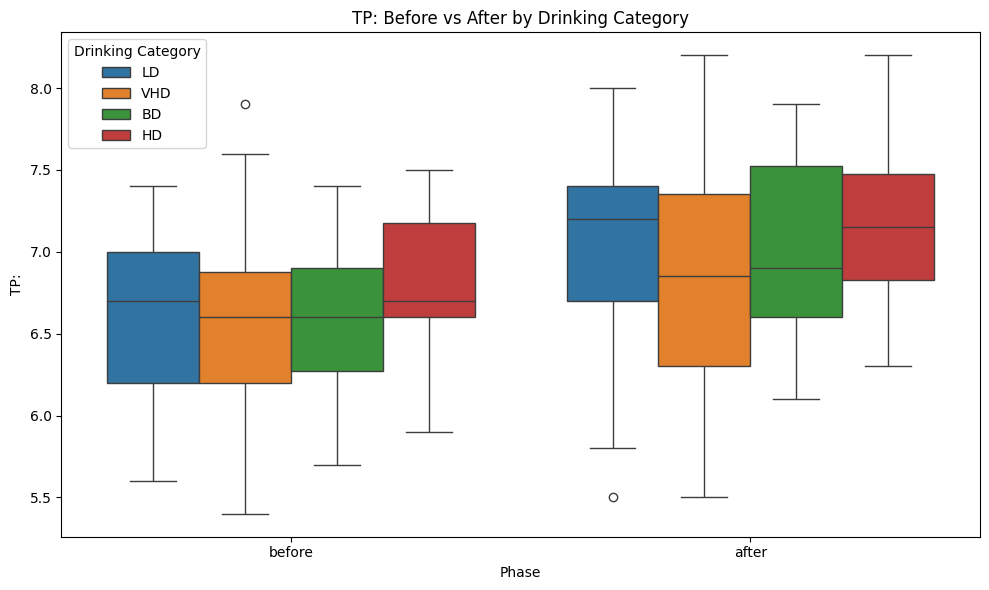

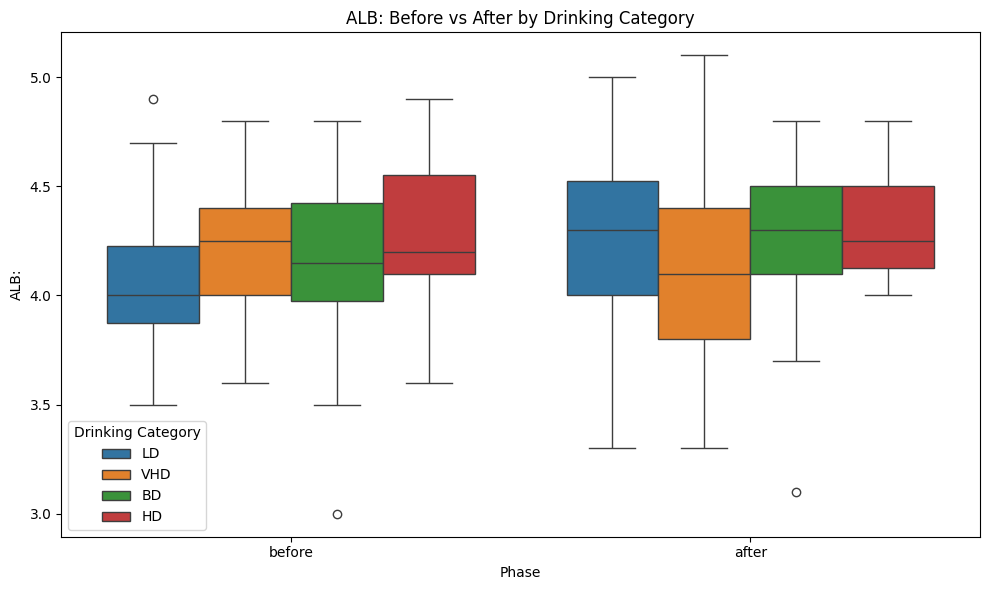

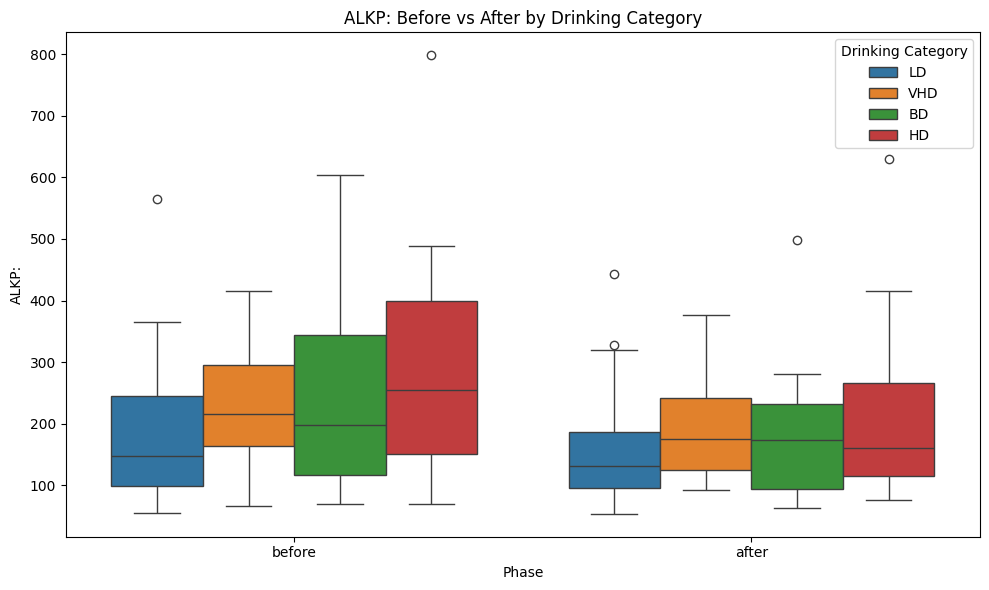

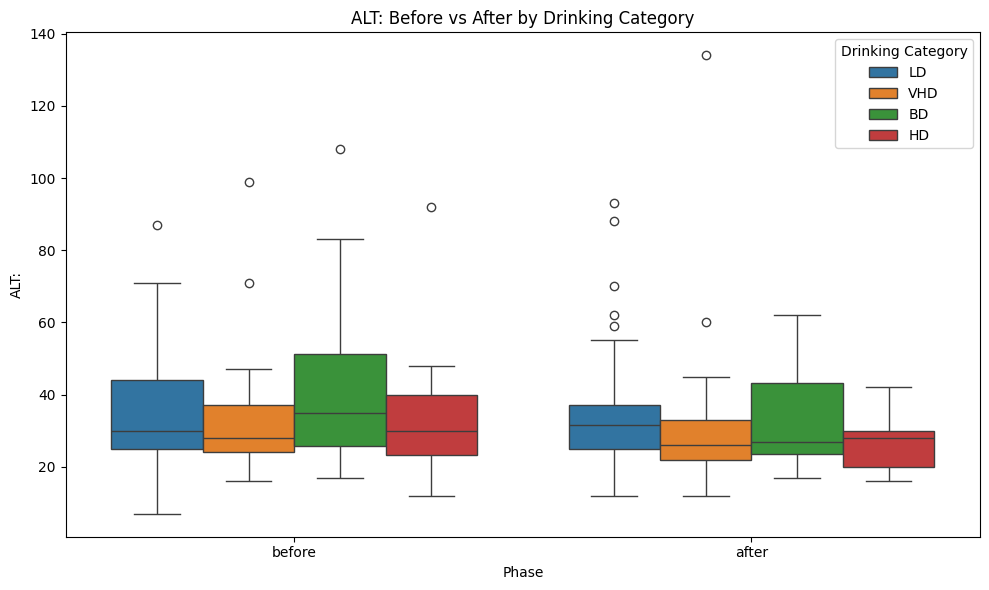

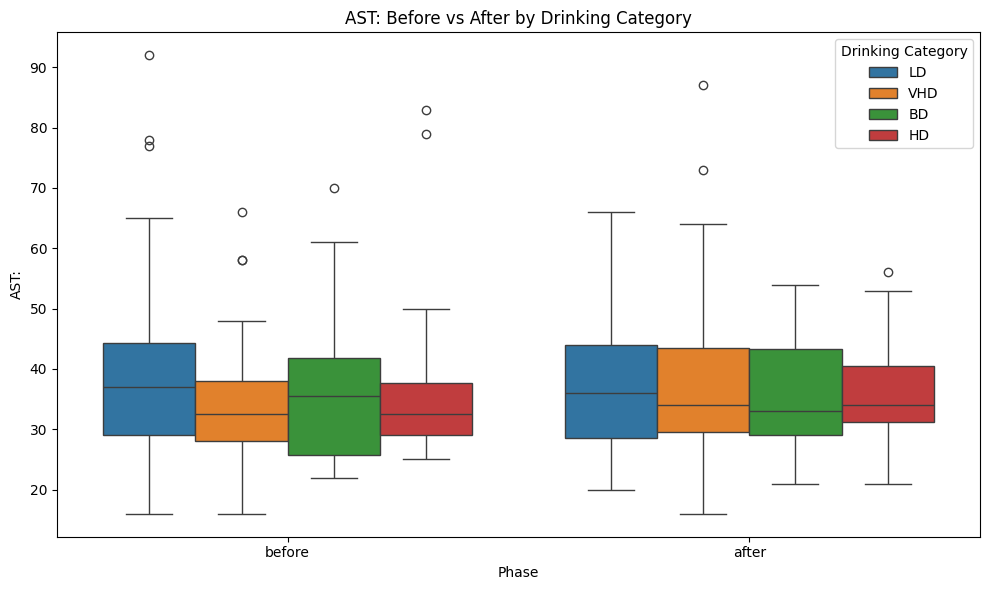

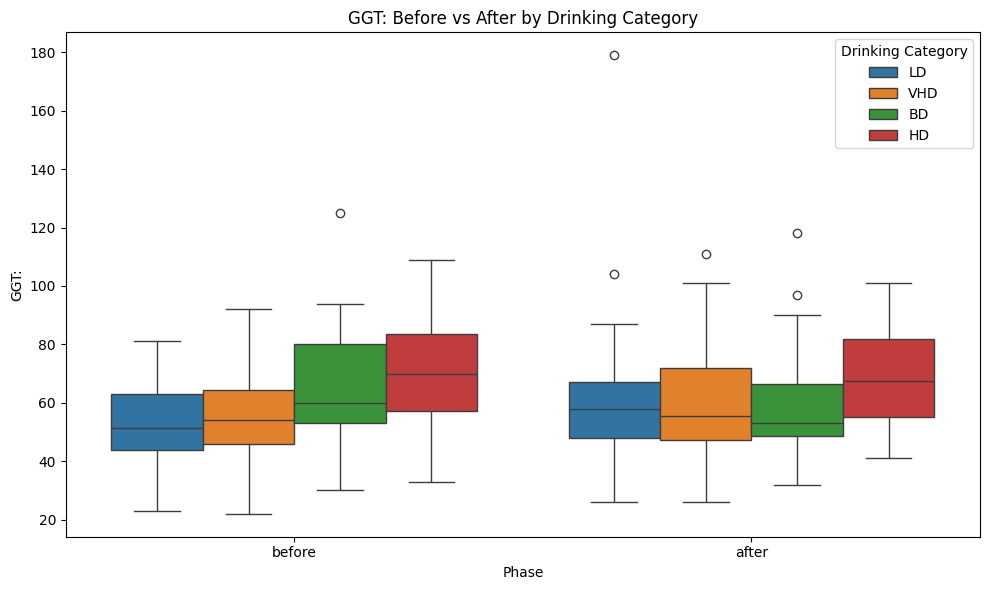

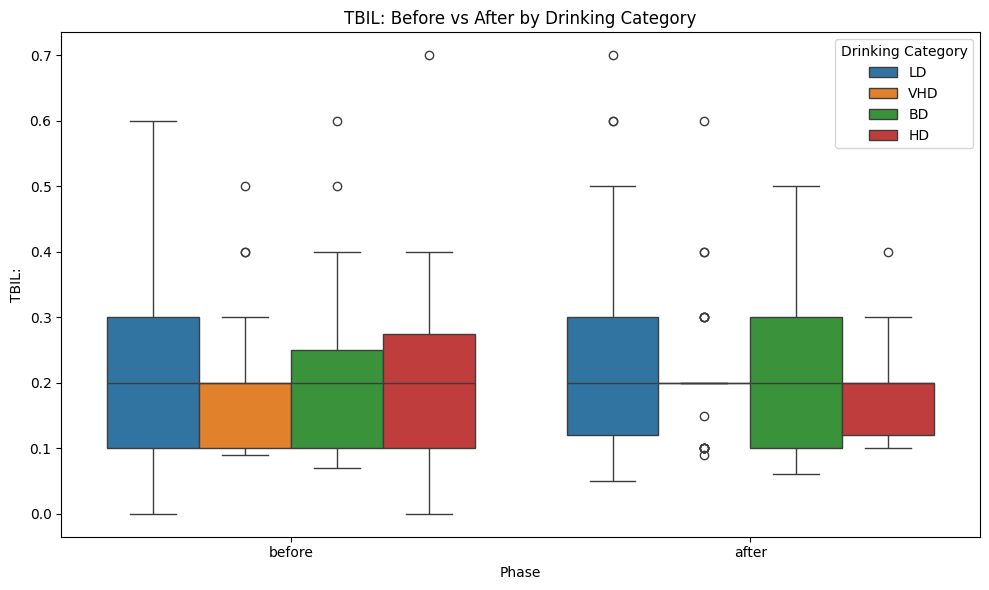

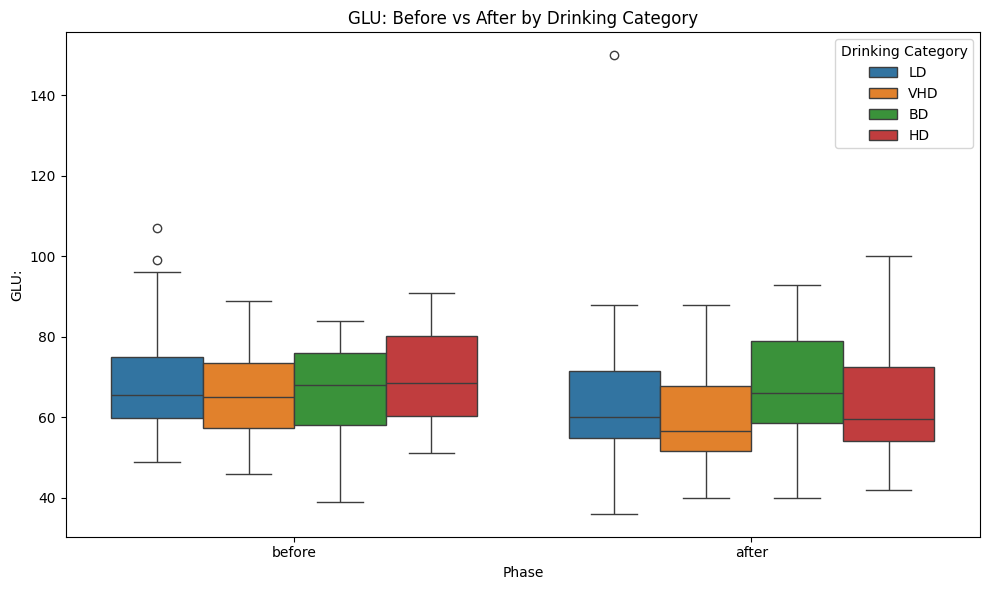

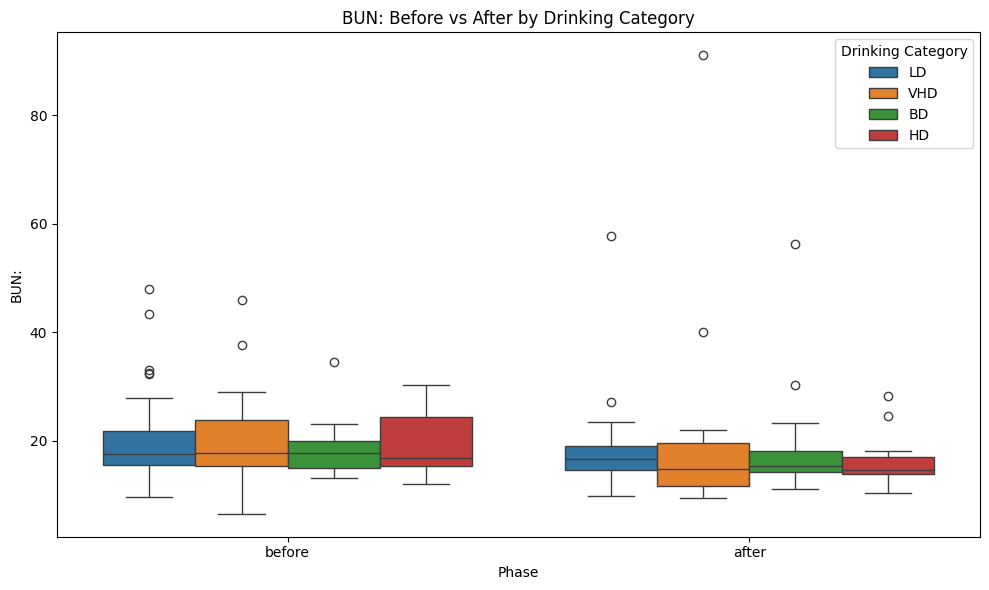

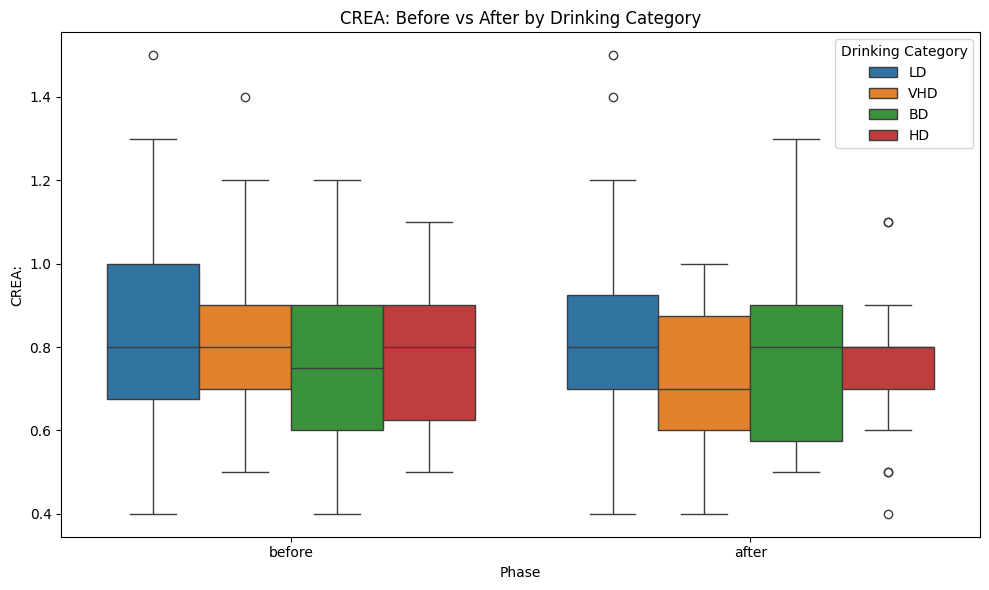

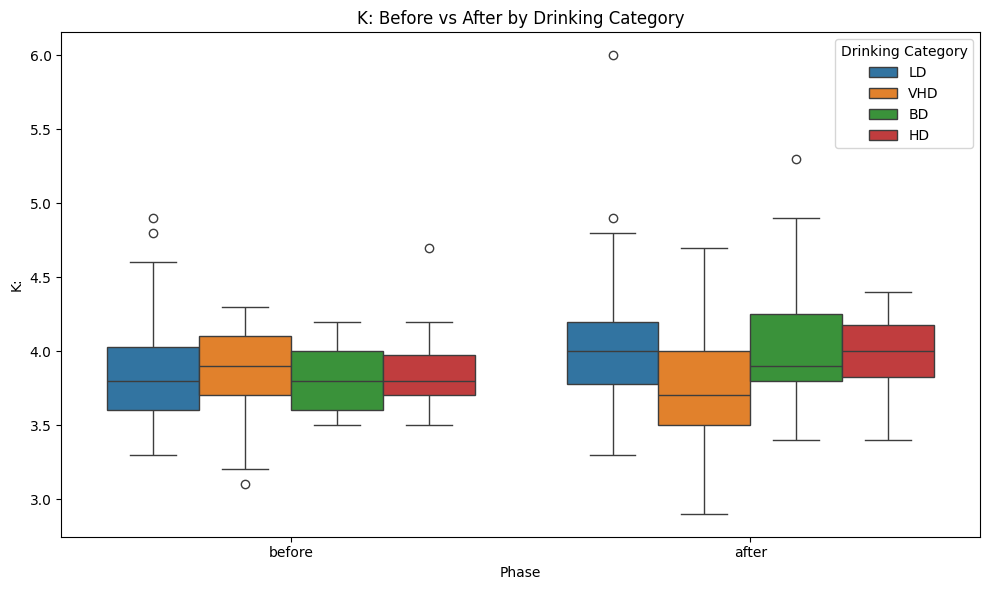

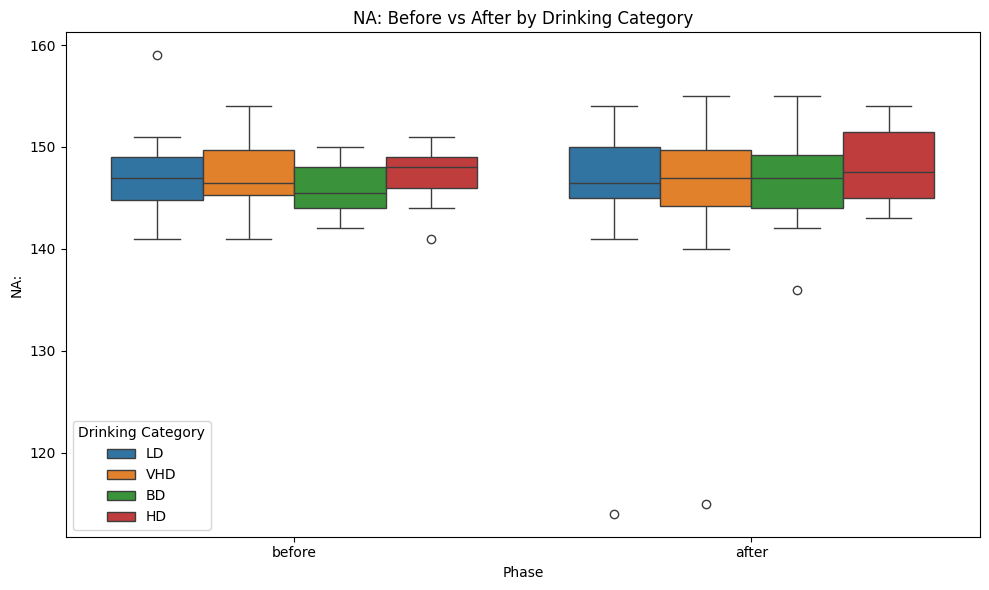

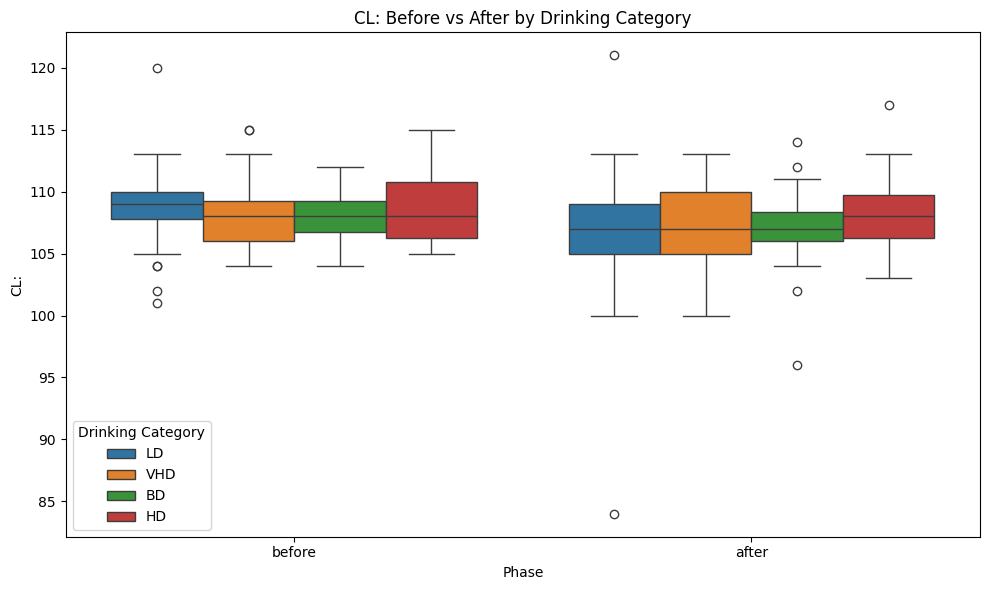

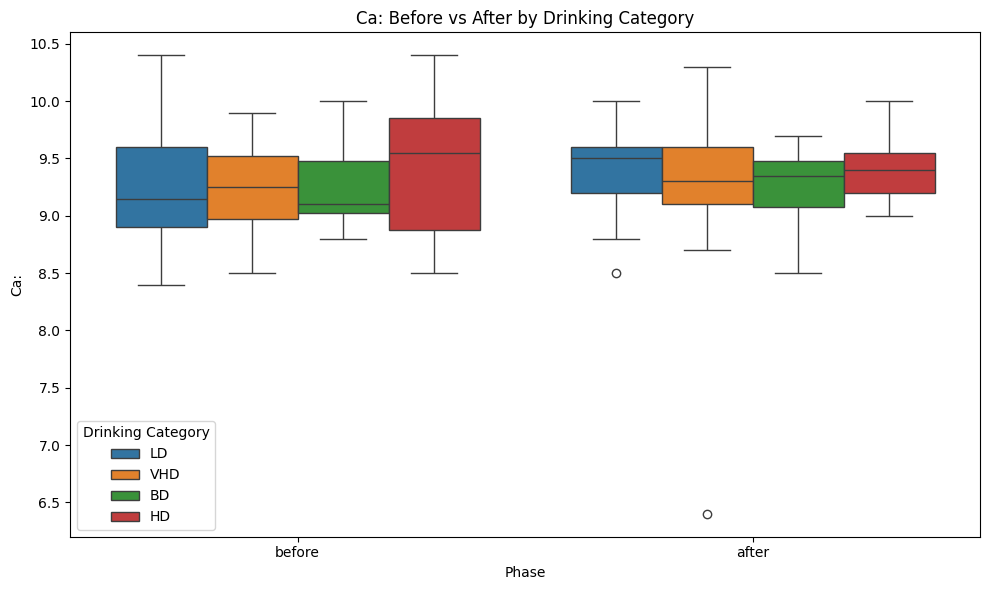

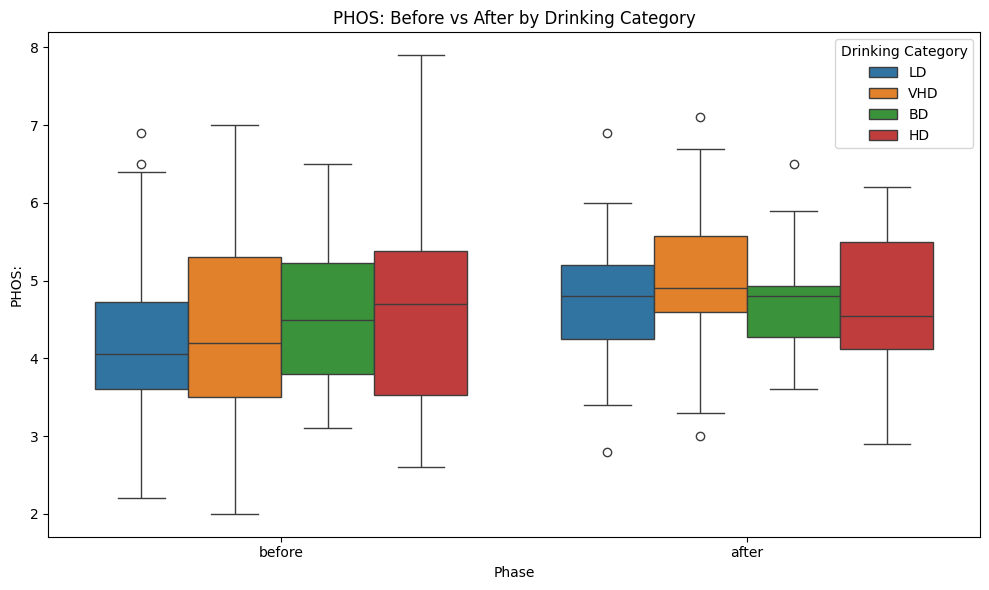

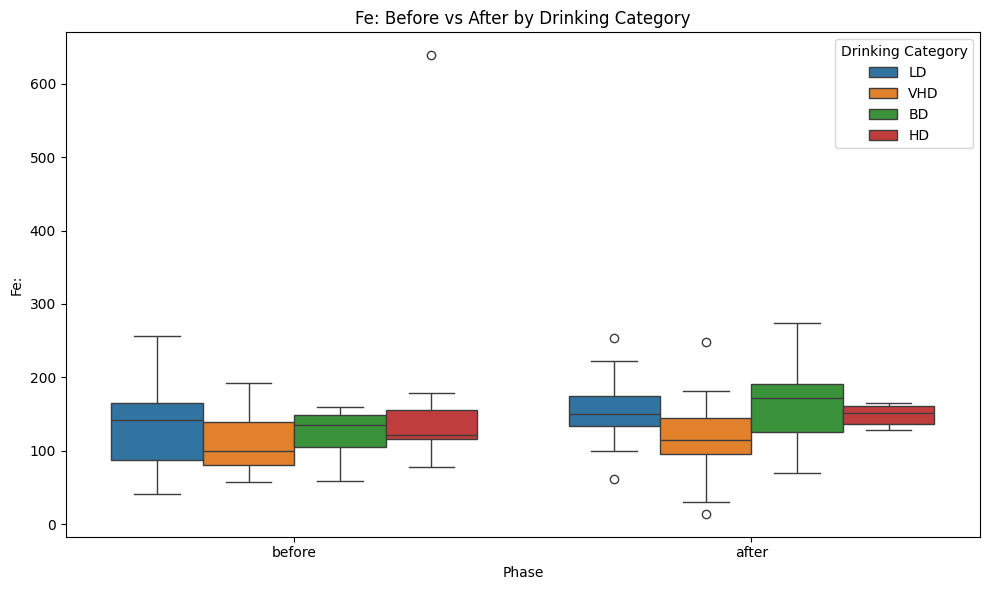

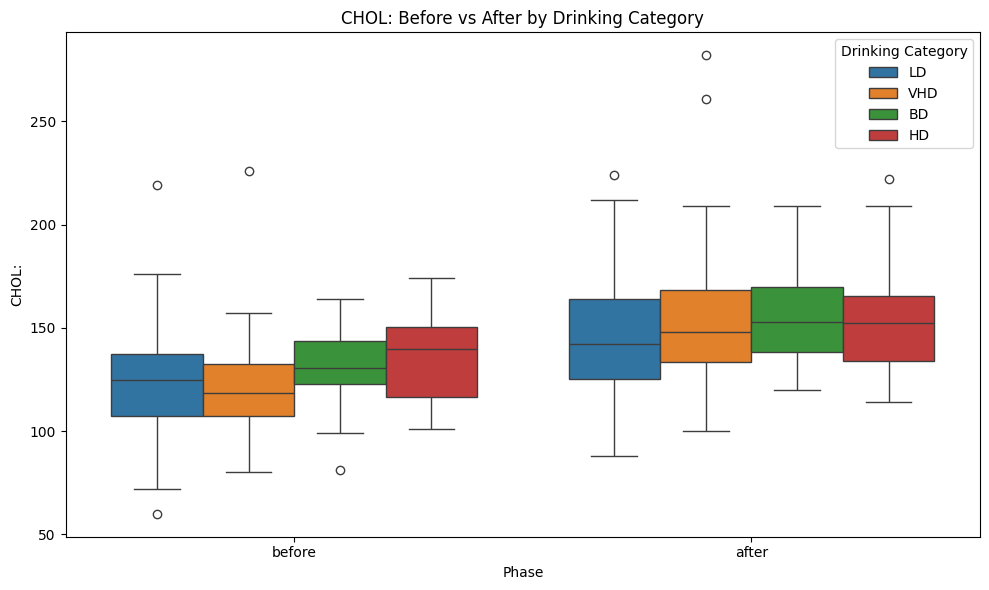

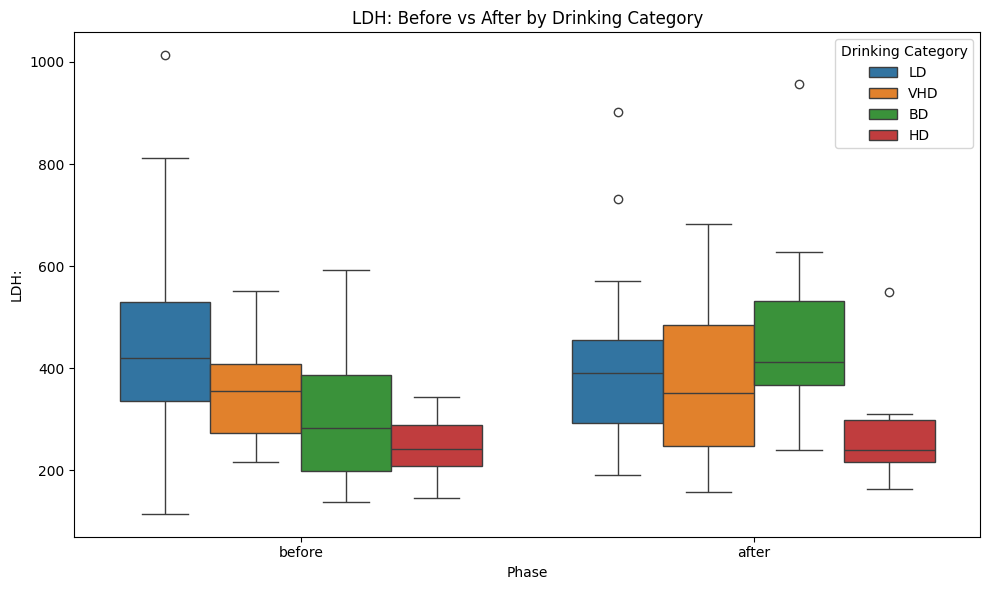

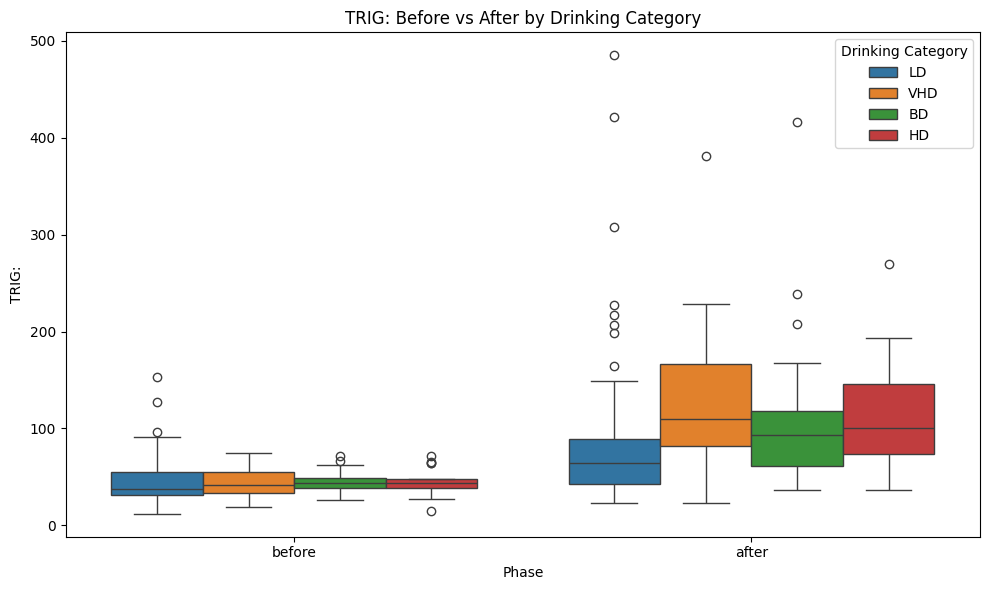

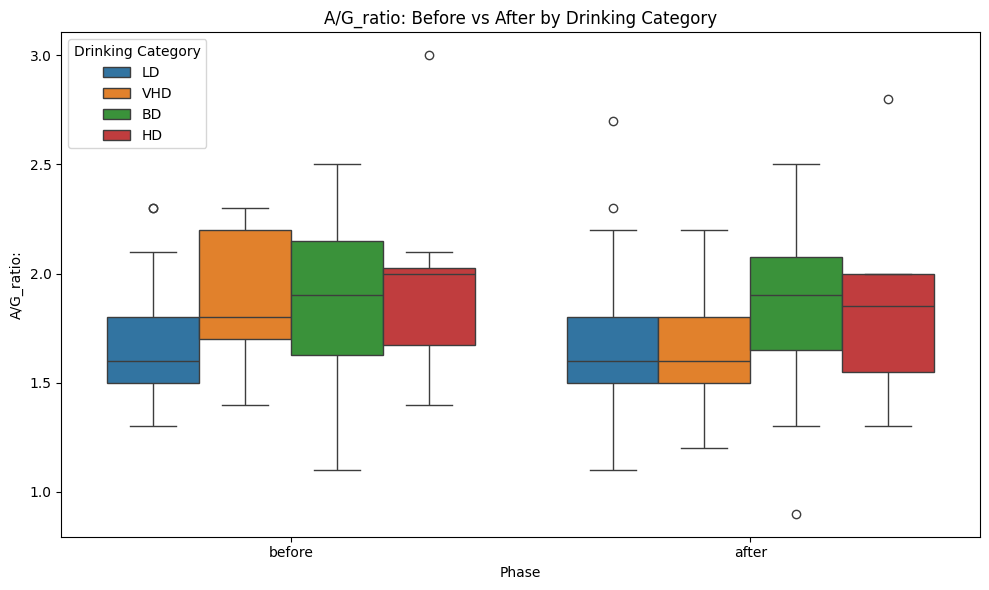

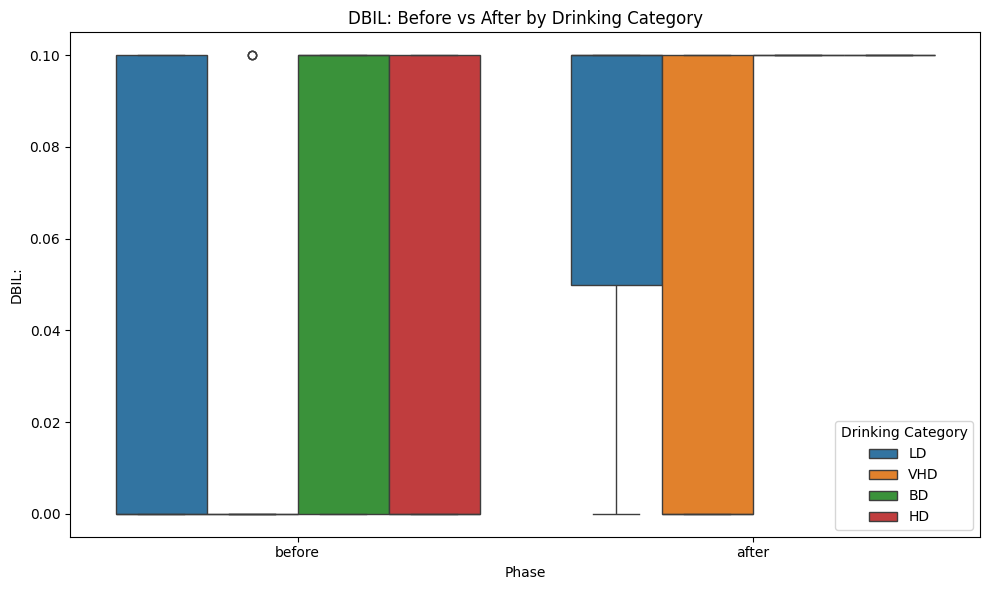

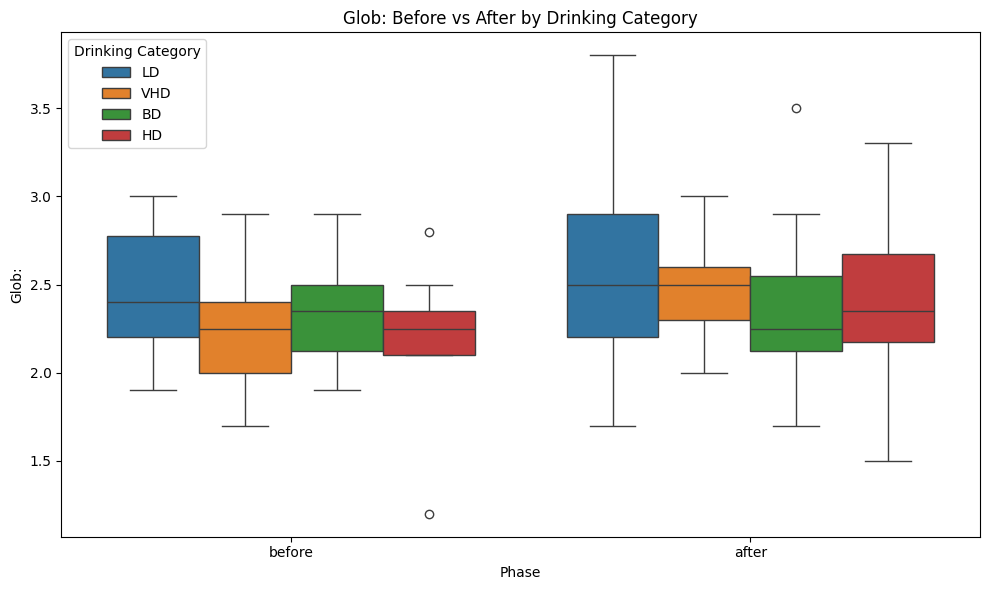

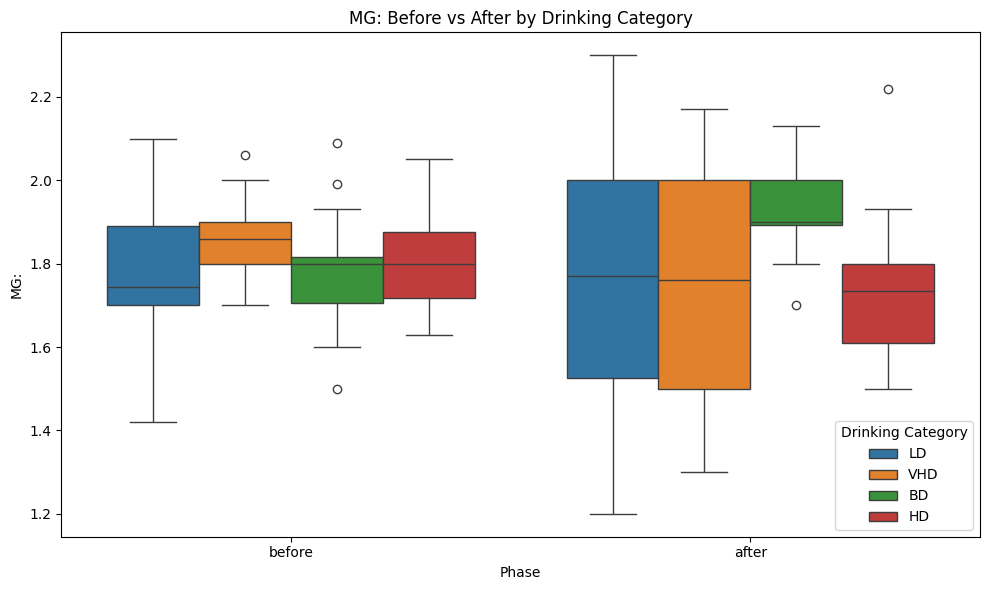

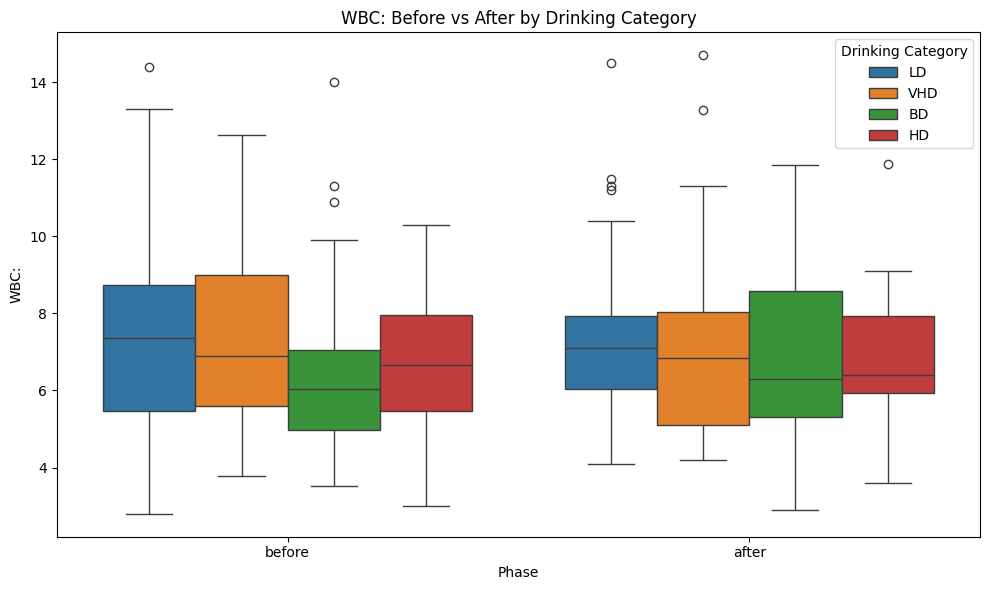

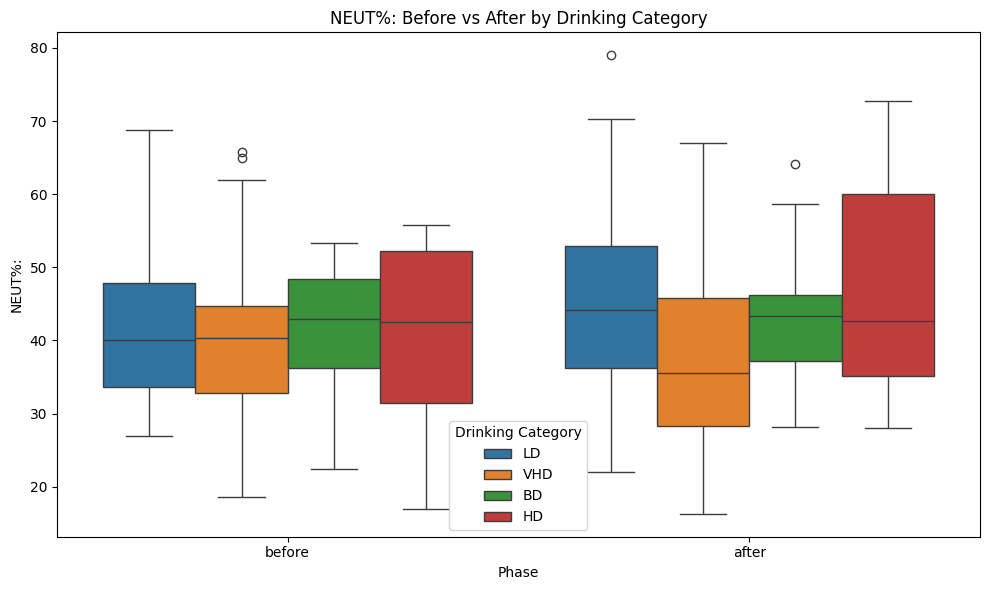

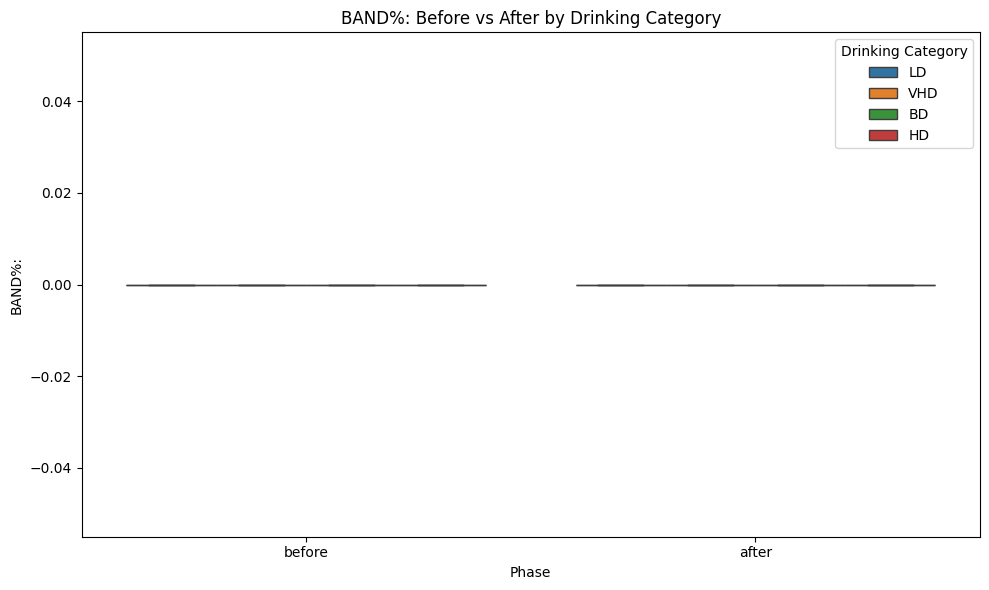

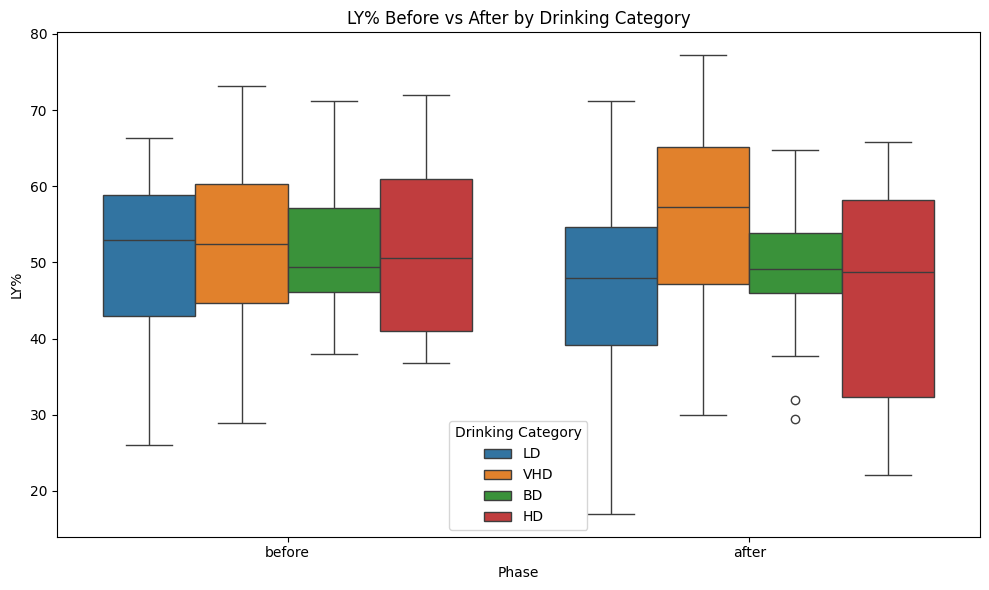

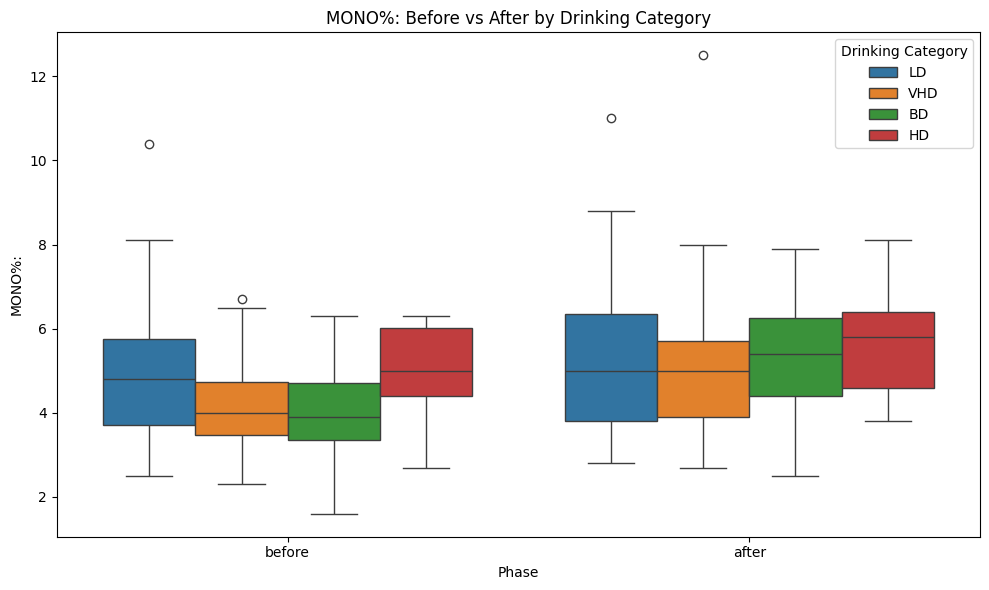

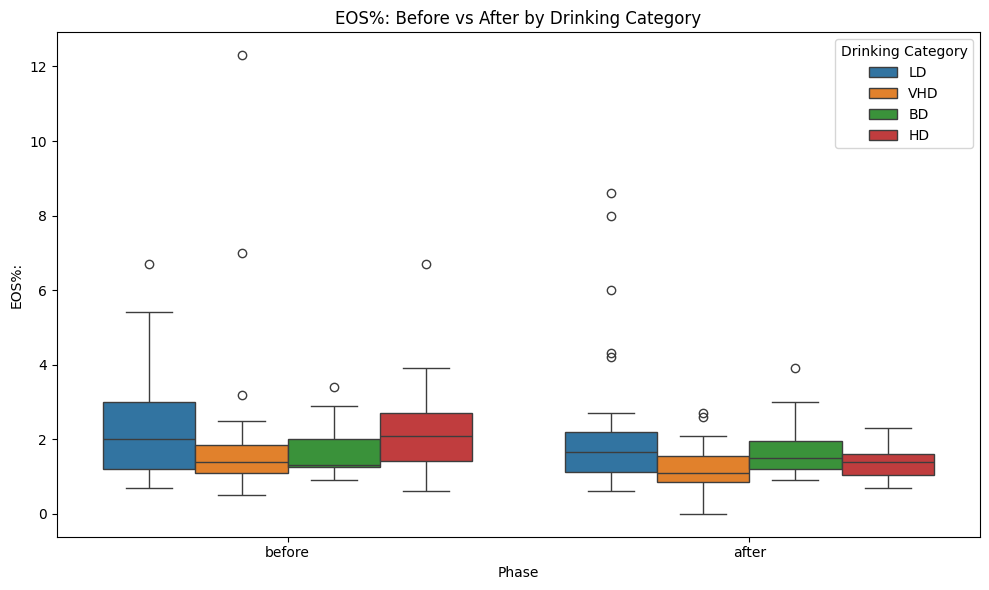

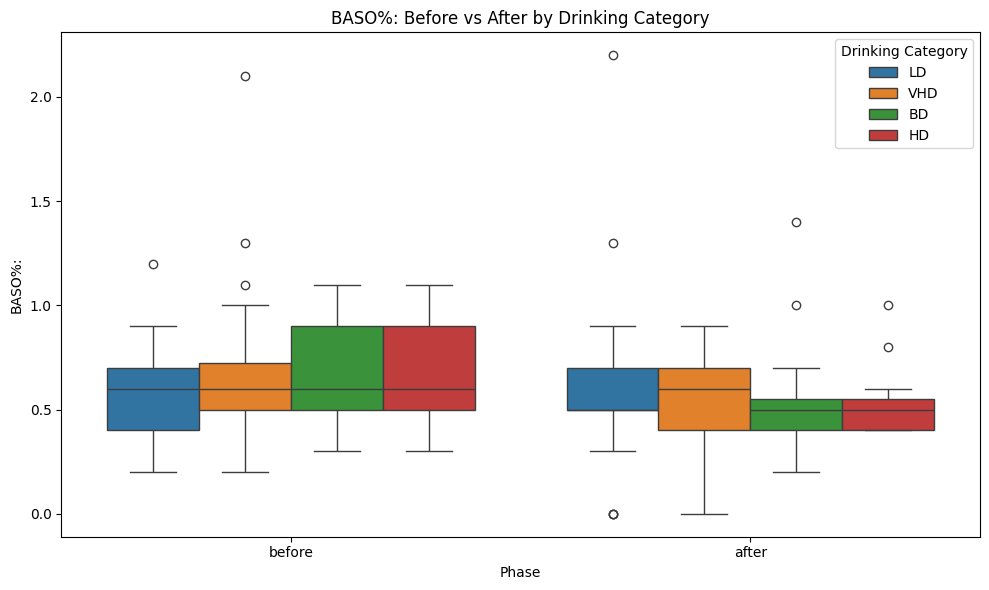

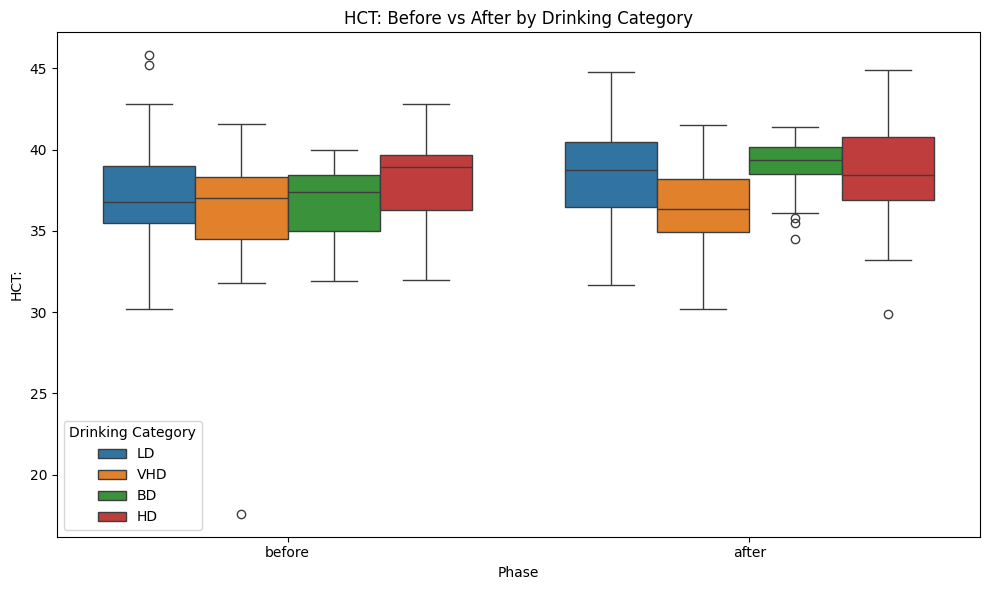

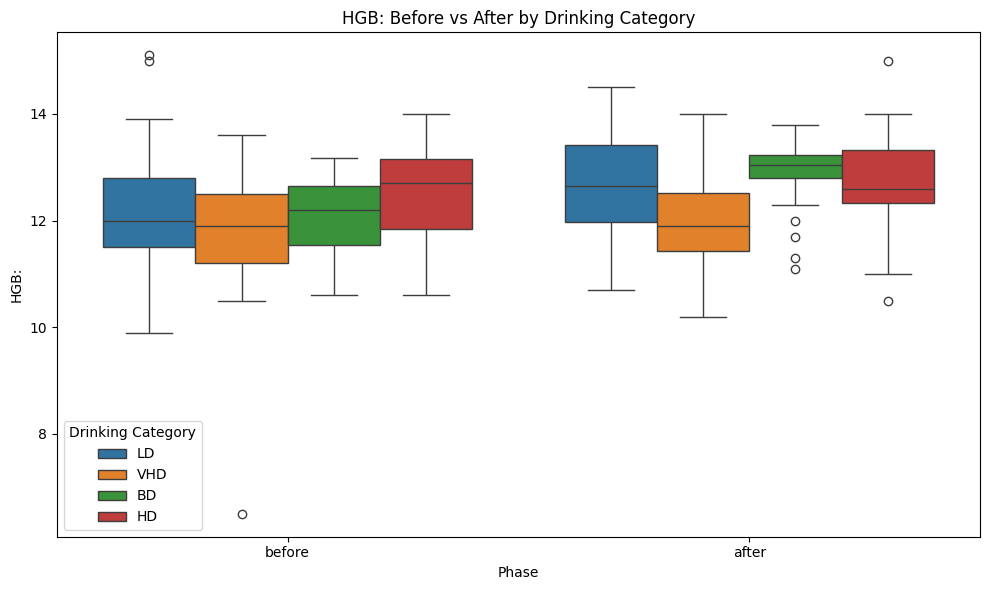

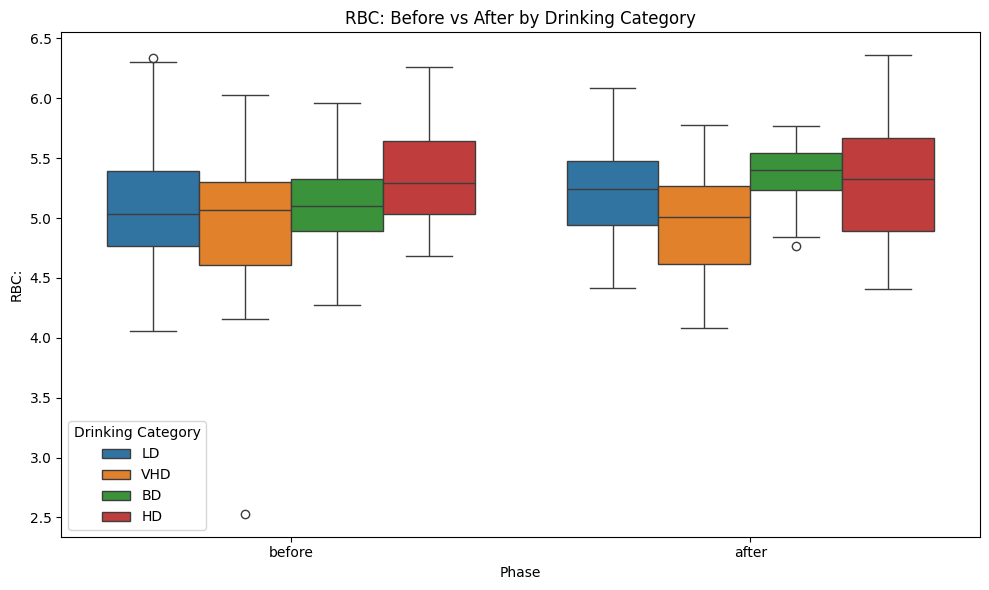

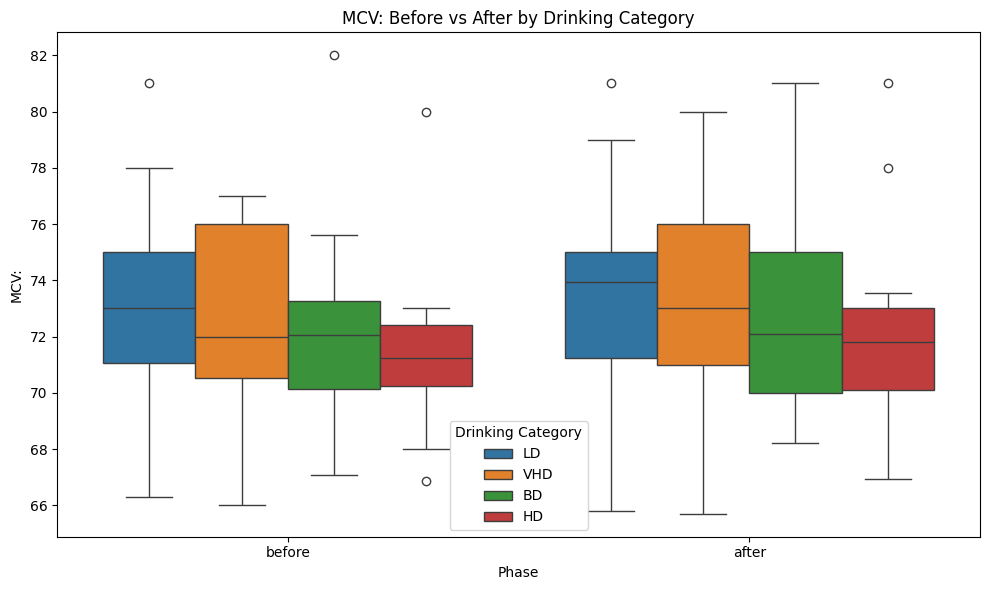

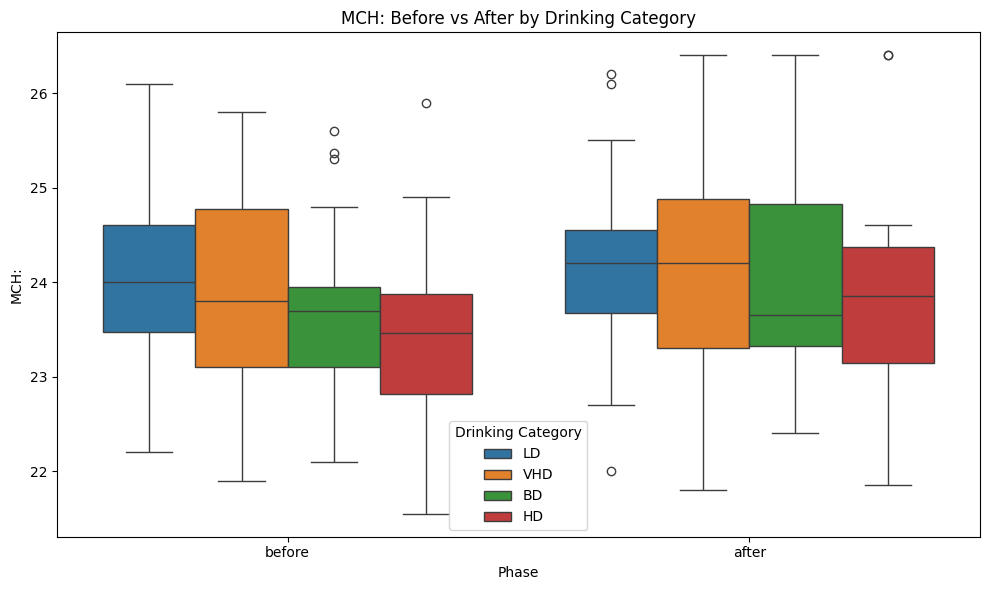

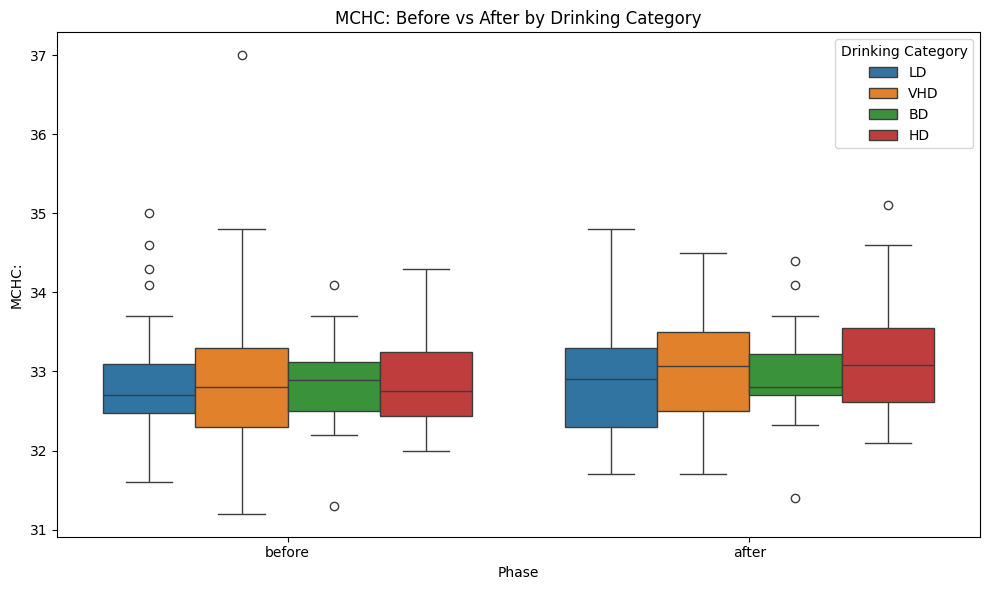

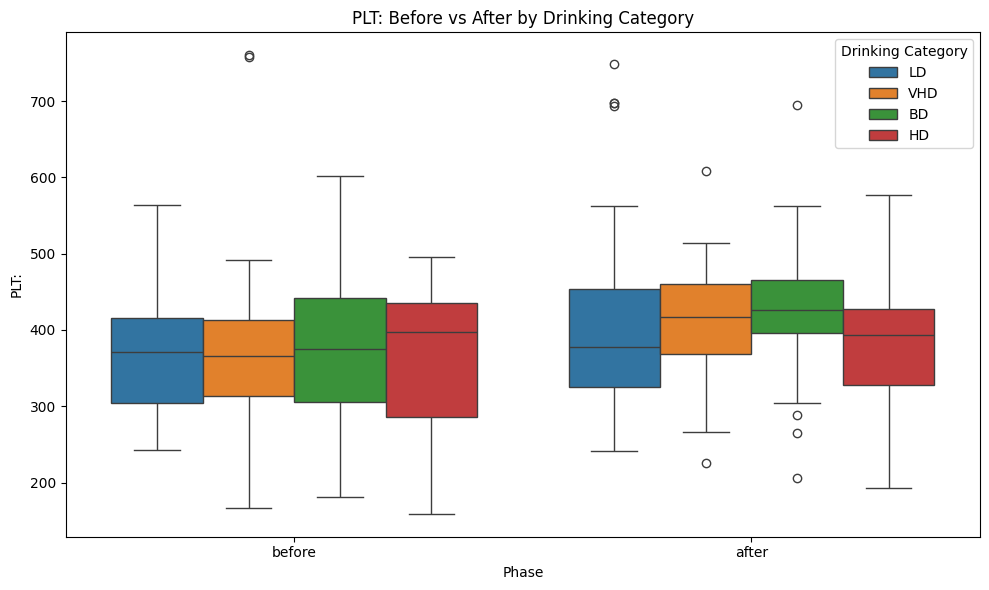

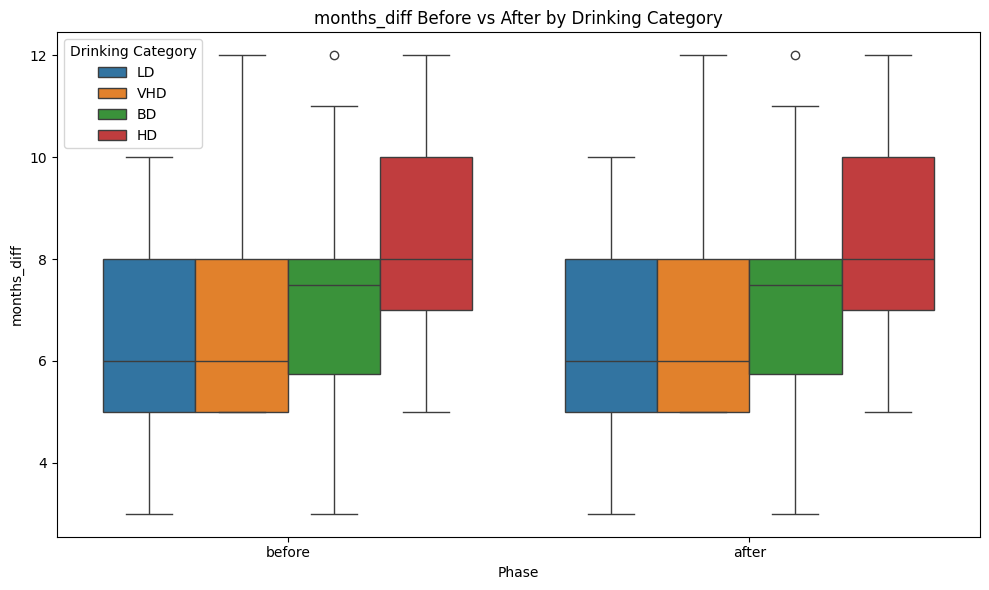

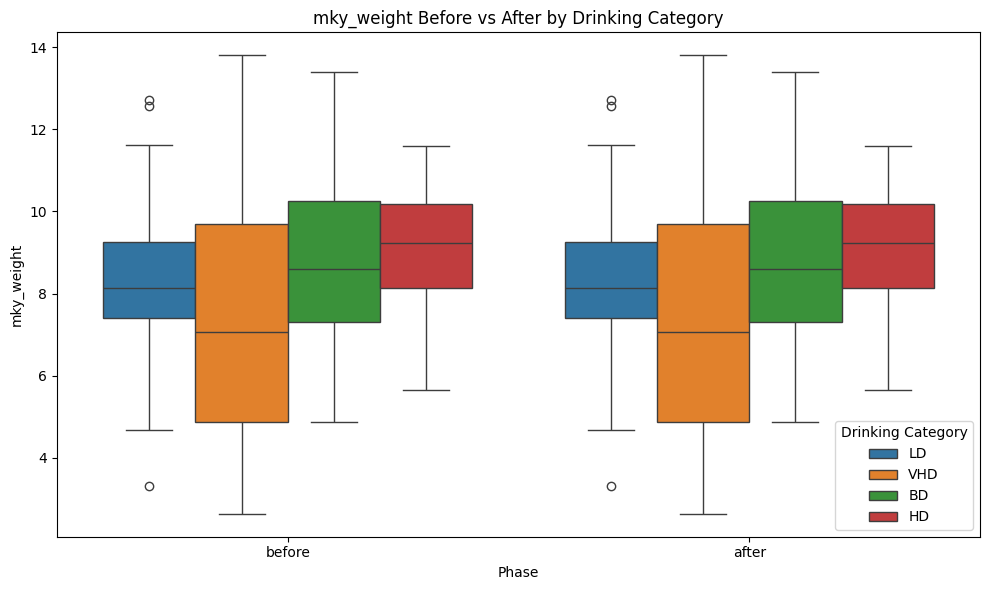

In [ ]:
import os
os.makedirs("biomarker_boxplots", exist_ok=True)

for biomarker in biomarker_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df_melted[df_melted['Biomarker'] == biomarker],
        x='phase',
        y='Value',
        hue='drinking_category'
    )
    plt.title(f"{biomarker} Before vs After by Drinking Category")
    plt.ylabel(biomarker)
    plt.xlabel("Phase")
    plt.legend(title="Drinking Category")
    plt.tight_layout()
    #plt.savefig(f"biomarker_boxplots/{biomarker}_boxplot.png")
    plt.show()


In [ ]:
#rename biomarker for naming converntion
df_melted['Biomarker'] = df_melted['Biomarker'].replace('A/G ratio:', 'A_G_ratio:')
liver_biomarkers = ['ALT:', 'AST:', 'GGT:', 'ALKP:', 'TBIL:', 'DBIL:', 'A_G_ratio:', 'Glob:', 'ALB:']


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Custom color palette for drinking categories
custom_palette = {
    'VHD': 'red',
    'LD': 'green',
    'HD': 'orange',
    'BD': 'blue'
}

# Sanitize filenames
def sanitize_filename(name):
    return re.sub(r'[^\w\-_.]', '_', name)

# Biomarker group definitions
biomarker_groups = {
    "Liver": liver_biomarkers,
    "Kidney": kidney_biomarkers,
    "Metabolic": metabolic_biomarkers,
    "Hematologic": hematological_biomarkers,
    "Immune": immune_biomarkers
}

# Create main folder
os.makedirs("grouped_biomarker_boxplots", exist_ok=True)

for group_name, biomarkers in biomarker_groups.items():
    group_folder = f"grouped_biomarker_boxplots/{group_name}"
    os.makedirs(group_folder, exist_ok=True)

    for biomarker in biomarkers:
        if biomarker not in df_melted['Biomarker'].unique():
            print(f"⚠️ Skipping missing biomarker: {biomarker}")
            continue

        plt.figure(figsize=(10, 6))
        sns.boxplot(
            data=df_melted[df_melted['Biomarker'] == biomarker],
            x='phase',
            y='Value',
            hue='drinking_category',
            palette=custom_palette
        )
        plt.title(f"{biomarker} by Phase and Drinking Category ({group_name})")
        plt.ylabel(biomarker)
        plt.xlabel("Phase")
        plt.legend(title="Drinking Category")
        plt.tight_layout()

        safe_name = sanitize_filename(biomarker)
        plt.savefig(f"{group_folder}/{safe_name}_boxplot.png")
        plt.close()


⚠️ Skipping missing biomarker: A_G_ratio:


In [ ]:
# Step 1: Prepare wide format with one row per monkey per biomarker phase
df_ba['phase'] = df_ba['phase'].str.lower()  # ensure consistent casing

# Set keys and pivot
df_wide = df_ba.pivot_table(
    index=['MATRR_ID', 'Species', 'drinking_category', 'mky_gender'],
    columns='phase',
    values=biomarker_cols
).reset_index()



In [ ]:
df_wide.columns = [
    col[0] if col[1] == '' else f"{col[0]}_{col[1]}"
    for col in df_wide.columns
]


In [ ]:
print(df_wide.columns.tolist()[:10])


['MATRR_ID', 'Species', 'drinking_category', 'mky_gender', 'A/G_ratio:_after', 'A/G_ratio:_before', 'ALB:_after', 'ALB:_before', 'ALKP:_after', 'ALKP:_before']


In [ ]:
for biomarker in biomarker_cols:
    col_before = f"{biomarker}_before"
    col_after = f"{biomarker}_after"
    col_delta = f"{biomarker}_delta"

    if col_before in df_wide and col_after in df_wide:
        df_wide[col_delta] = df_wide[col_after] - df_wide[col_before]


In [ ]:
delta_cols = [col for col in df_wide.columns if col.endswith('_delta')]

df_delta_melted = df_wide.melt(
    id_vars=['MATRR_ID', 'Species', 'drinking_category', 'mky_gender'],
    value_vars=delta_cols,
    var_name='Biomarker',
    value_name='Delta'
)

df_delta_melted['Biomarker'] = df_delta_melted['Biomarker'].str.replace('_delta', '')


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Folder to store plots
os.makedirs("delta_boxplots", exist_ok=True)

# Loop through unique biomarkers
for biomarker in df_delta_melted['Biomarker'].unique():
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df_delta_melted[df_delta_melted['Biomarker'] == biomarker],
        x='drinking_category',
        y='Delta',
        hue='Species',
        #palette=custom_palette
    )
    plt.axhline(0, linestyle='--', color='gray')
    plt.title(f"Δ {biomarker} (After - Before) by Drinking Category")
    plt.xlabel("Drinking Category")
    plt.ylabel(f"Change in {biomarker}")
    plt.tight_layout()

    safe_name = biomarker.replace('/', '_').replace(':', '')
    plt.savefig(f"delta_boxplots/{safe_name}_delta.png")
    plt.close()
